In [1]:
import distance
import csv
import random
import numpy
import pandas as pd
import math
import time
from IPython.display import Audio, display
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from sklearn.neighbors import KNeighborsClassifier

In [2]:
def allDone():
    urL = 'http://www.wavsource.com/snds_2018-06-03_5106726768923853/animals/cat_meow2.wav'
    display(Audio(url=urL, autoplay=True))

In [3]:
motifs = (numpy.genfromtxt('very_popular_motifs.csv',dtype='U'))
fams = (numpy.genfromtxt('very_popular_fams.csv',dtype='U'))
motifxFamMatrix = numpy.genfromtxt('very_popular_motifxFamMatrix.csv',delimiter=',',dtype=int)

all_characters = []
for motif in motifs:
    for c in motif:
        all_characters.append(c)
print (len(set(all_characters)))
amino_acids = ''.join(list(set(all_characters)))
num_amino_acids = (len(set(all_characters)))

max_len = (max( [len(x) for x in motifs] ))

20


In [4]:
def letterToIndex(letter):
    return amino_acids.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, num_amino_acids)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, num_amino_acids)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def motifToStringTensor(motif):
    motif = [letterToIndex(x) for x in motif]
    motif = torch.tensor(motif).unsqueeze(1)
    return (motif)

def getMotifAndFamForTraining(mIdx):
    motif = motifs[mIdx]
    motif_tensor = motifToStringTensor(motif)  
    fIdx = numpy.where(motifxFamMatrix[mIdx]==1)[0][0]
    fam = fams[fIdx]
    fam_tensor = torch.tensor(fIdx.reshape(1))
    return motif_tensor, fam_tensor

In [5]:
150

150

In [6]:
10*15

150

## <font color=red> Returning mu, mu !!!

In [7]:
20*15

300

In [8]:
HIDDEN_DIM_1 = 25
HIDDEN_DIM_2 = 100
HIDDEN_DIM_3 = 5
bi = 2

class SiameseVAE(nn.Module):
        
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(SiameseVAE, self).__init__()
        
        self.lstm = nn.LSTM(vocab_size, HIDDEN_DIM_1, bidirectional=True)
#         self.hidden = nn.Linear(HIDDEN_DIM_1 * bi, HIDDEN_DIM_2 * bi)
        self.mu = nn.Linear(HIDDEN_DIM_1 * bi, HIDDEN_DIM_2)
        self.cov = nn.Linear(HIDDEN_DIM_1 * bi, HIDDEN_DIM_2)
        
        self.lstm_d = nn.Linear(HIDDEN_DIM_2, HIDDEN_DIM_1)
        self.hidden_d = nn.Linear(HIDDEN_DIM_1, vocab_size)
    
    def forward_once(self, sentence, maxLen):  
        lstm_out, (h,c) = self.lstm( sentence )
#         hidden1 = self.hidden( lstm_out[:,:] )   # lstm_out[-1,:]
        
        mu = self.mu( lstm_out[:,:] )
        cov = self.cov( lstm_out[:,:] )
        z = self.reparameterize(mu, cov)

        rnn_out = self.lstm_d( z )
        result = self.hidden_d(rnn_out)
        return sentence, mu, mu, cov
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)  
        else:
            return mu
        
    def forward(self, input1, input2, maxLen1, maxLen2):
        (result, z, mu, cov) = self.forward_once(input1, maxLen1)
        (result_2, z_2, mu_2, cov_2) = self.forward_once(input2, maxLen2)
        return (result, z, mu, cov) , (result_2, z_2, mu_2, cov_2)

In [35]:
def getBatch(idc):
    
    mIdx1_batch = []
    mIdx2_batch = []
    target1_batch = []
    target2_batch = []
    label_batch = []
    mIdc1 = []
    mIdc2 = []
    switch = 0
    
    while switch < BATCH_SIZE:
        mIdx1 = random.choice( idc )  #random.choice(trainIdc)
        motif1 = motifs[mIdx1]
        motif_tensor1 = lineToTensor(motif1)

        fIdx1 = numpy.where(motifxFamMatrix[mIdx1]==1)
        fam1 = fams[fIdx1]

        mIdx2 = random.choice( idc )  #random.choice(trainIdc)
        motif2 = motifs[mIdx2]
        motif_tensor2 = lineToTensor(motif2)

        fIdx2 = numpy.where(motifxFamMatrix[mIdx2]==1)
        fam2 = fams[fIdx2]
        
        label = distance.jaccard(set(fam1),set(fam2))
        true_label = round(label)
        label = torch.tensor([label]).unsqueeze(0)
        
#         label = torch.tensor([label]).unsqueeze(0) 

#         if set(fam1).intersection(set(fam2)): 
#             label = torch.tensor([1.0]).unsqueeze(0) 
#         else: 
#             label = torch.tensor([0.0]).unsqueeze(0)
    
        if switch%2 != true_label:
            continue
        
        mIdx1_batch.append(motif_tensor1)
        mIdx2_batch.append(motif_tensor2)
        label_batch.append(label)
        
        motif_idc1 = [letterToIndex(aa) for aa in motif1]
        motif_idc1 = torch.tensor(motif_idc1)
        target1_batch.append(motif_idc1)
        mIdc1.append(mIdx1)
        
        motif_idc2 = [letterToIndex(aa) for aa in motif2]
        motif_idc2 = torch.tensor(motif_idc2)
        target2_batch.append(motif_idc2)
        mIdc2.append(mIdx2)

        switch += 1

    mIdx1_batch = torch.nn.utils.rnn.pad_sequence(mIdx1_batch, batch_first=False).squeeze(2)
    mIdx2_batch = torch.nn.utils.rnn.pad_sequence(mIdx2_batch, batch_first=False).squeeze(2)

    maxLen2 = mIdx2_batch.shape[0]
    maxLen1 = mIdx1_batch.shape[0]
    
    label_batch = torch.stack(label_batch)
    
    target1_batch = torch.nn.utils.rnn.pad_sequence(target1_batch, batch_first=False).squeeze(-1)
    target2_batch = torch.nn.utils.rnn.pad_sequence(target2_batch, batch_first=False).squeeze(-1)
    
    return (mIdx1_batch, mIdx2_batch, maxLen1, maxLen2, label_batch, target1_batch, target2_batch,
           mIdc1, mIdc2)

In [36]:
trainSetSize = int( len(motifs) * .99)
temp_trainIdc = random.sample(range (len(motifs)), trainSetSize)

valSetSize = int( trainSetSize * .01 )
valIdc = random.sample(temp_trainIdc, valSetSize)
trainIdc = [i for i in temp_trainIdc if i not in valIdc]

testIdc = [i for i in range(len(motifs)) if i not in temp_trainIdc]


print (len(trainIdc))
print (len(valIdc))
print (len(testIdc))

random.seed(46)
random.shuffle(trainIdc)
random.seed(46)
random.shuffle(valIdc)
random.seed(46)
random.shuffle(testIdc)

6586
66
68


In [37]:
def siamese_loss(z1, z2, label, margin=2.0):
    euclidean_distance = F.pairwise_distance(z1, z2) 
    loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss_contrastive

def recon_and_KLD_loss(recon_x, x, mu, cov, maxLen, switch=0):
    criterion = nn.CrossEntropyLoss()
    CCE = criterion(recon_x, x)
    KLD = (-0.5 * torch.sum(cov - torch.pow(mu, 2) - torch.exp(cov) + 1, 1)).mean().squeeze()
    
    return CCE

In [38]:
from torch import optim

vocab_size = len(amino_acids)

model = SiameseVAE(embedding_dim = 100, hidden_dim = 25,
                       vocab_size = len(amino_acids)) 

name_guess_samples = []
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.005 )
# optimizer = optim.Adadelta(model.parameters(),lr = 0.01 )

# optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

loss_history = []
acc_history = []
val_loss_history = []

s = 1
for epoch in range(5):
    
    BATCH_SIZE = 32
    tot_loss = []
    
    for bIdx in range(250): #range(())):len(trainIdc) len(motifs) 
        optimizer.zero_grad()
        
        (mIdx1_batch, mIdx2_batch, maxLen1, maxLen2, label_batch, target1_batch, target2_batch,
           mIdc1, mIdc2) = getBatch(trainIdc)
        
        (output, z, mu, cov) , (output2, z_2, mu_2, cov_2) = model(mIdx1_batch, mIdx2_batch, maxLen1, maxLen2)
                
        output = output.view(-1, vocab_size)
        target1_batch = target1_batch.view(-1)
        output2 = output2.view(-1, vocab_size)
        target2_batch = target2_batch.view(-1)
        
        
        # LOSS FUNCTIONS ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
        loss1 = siamese_loss(z, z_2, label_batch, margin=2.0)
        loss2_b1 = recon_and_KLD_loss(output, target1_batch, mu, cov, maxLen1)
        loss2_b2 = recon_and_KLD_loss(output2, target2_batch, mu_2, cov_2, maxLen2)
                
        loss = loss1 * 2 + loss2_b1 + loss2_b2
        loss = loss1
        loss.backward()
        
        tot_loss.append(loss)
        optimizer.step()
        
        if bIdx % 25 == 0 :
            print("Iter {}\nEpoch number {}\nCurrent loss {}".format(s,epoch+1, sum(tot_loss)/len(tot_loss) ))
            loss_history.append( sum(tot_loss)/len(tot_loss) )

            # ------ ACCURACY -----
            (mIdx1_batch, mIdx2_batch, maxLen1, maxLen2, label_batch, target1_batch, target2_batch,
             mIdc1, mIdc2) = getBatch(trainIdc)
            (output, z, mu, cov) , (output2, z_2, mu_2, cov_2) = model(mIdx1_batch, mIdx2_batch, maxLen1, maxLen2)
            
            scores = []
            
            output = output.transpose(0,1)
            mIdx1_batch = mIdx1_batch.transpose(0,1)
            
            # only look at half of them ... ?
            for i, samp_res in enumerate(output):
                
                length = sum([ 1 for l in motifs[ mIdc1[i] ] if l != '_' ])
                pred = samp_res.argmax(1).detach().numpy()
                true = mIdx1_batch[i].argmax(1).detach().numpy()
                score = numpy.sum([1 for j in range(length) if (true[j]==pred[j] and true[j] != 0)])
                score /= length
                scores.append( score )
                if i==10:
                    true_name = motifs[ mIdc1[i] ]
                    pred_name = ''.join([amino_acids[j] for j in pred])
                    
                    print (pred_name, "|",true_name,  numpy.sum([1 for j in range(length) if (true[j]==pred[j])])/length )
                    name_guess_samples.append([pred_name,true_name])

            accuracy = sum(scores) / BATCH_SIZE
            acc_history.append(accuracy)
            
            # ------ VALIDATION LOSS -----
#             (mIdx1_batch, mIdx2_batch, maxLen1, maxLen2, label_batch, target1_batch, target2_batch,
#              mIdc1, mIdc2) = getBatch(valIdc)
#             (output, z, mu, cov) , (output2, z_2, mu_2, cov_2) = model(mIdx1_batch, mIdx2_batch, maxLen1, maxLen2)
            
#             output = output.view(-1, vocab_size)
#             target1_batch = target1_batch.view(-1)
#             output2 = output2.view(-1, vocab_size)
#             target2_batch = target2_batch.view(-1)
            
#             loss1 = siamese_loss(z, z_2, label_batch, margin=2.0)
# #             loss2_b1 = recon_and_KLD_loss(output, target1_batch, mu, cov, maxLen1)
# #             loss2_b2 = recon_and_KLD_loss(output2, target2_batch, mu_2, cov_2, maxLen2)

# #             loss = loss1 + loss2_b1 + loss2_b2
#             loss = loss1 
            
#             val_loss_history.append(loss)
#             print("Val loss: {}\n".format(loss))
            
            print("Accuracy:",accuracy)
            
            
        s+=1
            

Iter 1
Epoch number 1
Current loss 2.1675961017608643
DFPKKPLTPYFRFFM | DFPKKPLTPYFRFFM 1.0
Accuracy: 0.9791666666666667
Iter 26
Epoch number 1
Current loss 1.3429930210113525
RGGPISFSSSRSGRR | RGGPISFSSSRSGRR 1.0
Accuracy: 0.96875
Iter 51
Epoch number 1
Current loss 1.1733760833740234
HGMDRVGSEIERMGL | HGMDRVGSEIERMGL 1.0
Accuracy: 0.9812500000000001
Iter 76
Epoch number 1
Current loss 1.1145862340927124
SEVTRMTSGRSGVGV | SEVTRMTSGRSGVGV 1.0
Accuracy: 0.9708333333333334
Iter 101
Epoch number 1
Current loss 1.0852129459381104
KMKLAQQYVMTSLQQ | KMKLAQQYVMTSLQQ 1.0
Accuracy: 0.9770833333333334
Iter 126
Epoch number 1
Current loss 1.0673089027404785
HDLTETSYLPRQDLE | HDLTETSYLPRQDLE 1.0
Accuracy: 0.9750000000000001
Iter 151
Epoch number 1
Current loss 1.0560436248779297
KKKSEPSSPDHGSST | KKKSEPSSPDHGSST 1.0
Accuracy: 0.9687500000000001
Iter 176
Epoch number 1
Current loss 1.0463690757751465
GPRGQLASPDAPGPG | GPRGQLASPDAPGPG 1.0
Accuracy: 0.9791666666666667
Iter 201
Epoch number 1
Current 

In [39]:
def getSampForTesting(idx):
    
    mIdx = idx  
    motif = motifs[mIdx]
    motif_tensor = lineToTensor(motif)

    mIdx_batch = [motif_tensor]

    motif_idc = [letterToIndex(aa) for aa in motif]
    motif_idc = torch.tensor(motif_idc)
    target_batch = [motif_idc]

    mIdx_batch = torch.nn.utils.rnn.pad_sequence(mIdx_batch, batch_first=False).squeeze(2)

    maxLen = mIdx_batch.shape[0]
        
    target_batch = torch.nn.utils.rnn.pad_sequence(target_batch, batch_first=False).squeeze(-1)
    
    return (mIdx_batch, maxLen, target_batch)

In [41]:
scores = []
test_name_guesses = []
embeds = []
BATCH_SIZE = 1

for idx in range(len(motifs)):
    (mIdx_batch, maxLen, target_batch) = getSampForTesting(idx)
    
    out, z, mu, cov = model.forward_once(mIdx_batch, maxLen)
    embeds.append(z.reshape(-1))

    out = out.transpose(0,1)
    mIdx_batch = mIdx_batch.transpose(0,1)

    length = sum([ 1 for l in motifs[ idx ] if l != '_' ])
    pred = out[0].argmax(1).detach().numpy()
    true = mIdx_batch[0].argmax(1).detach().numpy()
    
    score = numpy.sum([1 for j in range(length) if (true[j]==pred[j] and true[j] != 0)])
    score /= length
    scores.append( score )
    
    true_name = motifs[ idx ]
    pred_name = ''.join([amino_acids[j] for j in pred])
        
    test_name_guesses.append([pred_name,true_name])

In [42]:
embedding1 = numpy.array([x.detach().numpy() for x in embeds])
print (embedding1.shape)
# embedding1 = numpy.vstack(embedding1)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pos_pca = pca.fit_transform(embedding1)

(6720, 1500)


In [43]:
import umap.umap_ as umap
import time

umapper = umap.UMAP(
    n_neighbors=200,
    min_dist=0.1,
    n_components=2,
    metric='euclidean' )

s = time.time()
pos_umap = umapper.fit_transform(embedding1)
print ("secs: %5.3f" % (time.time()-s))
allDone()

secs: 56.510


In [44]:
# import os
# os.mkdir("pooppppp")

fave_fams = ['Src','MAPK','CK2','PIKK','PKA']

In [45]:
allDone()

In [58]:
import os
os.mkdir("vaeall")
os.mkdir("vaeFave")

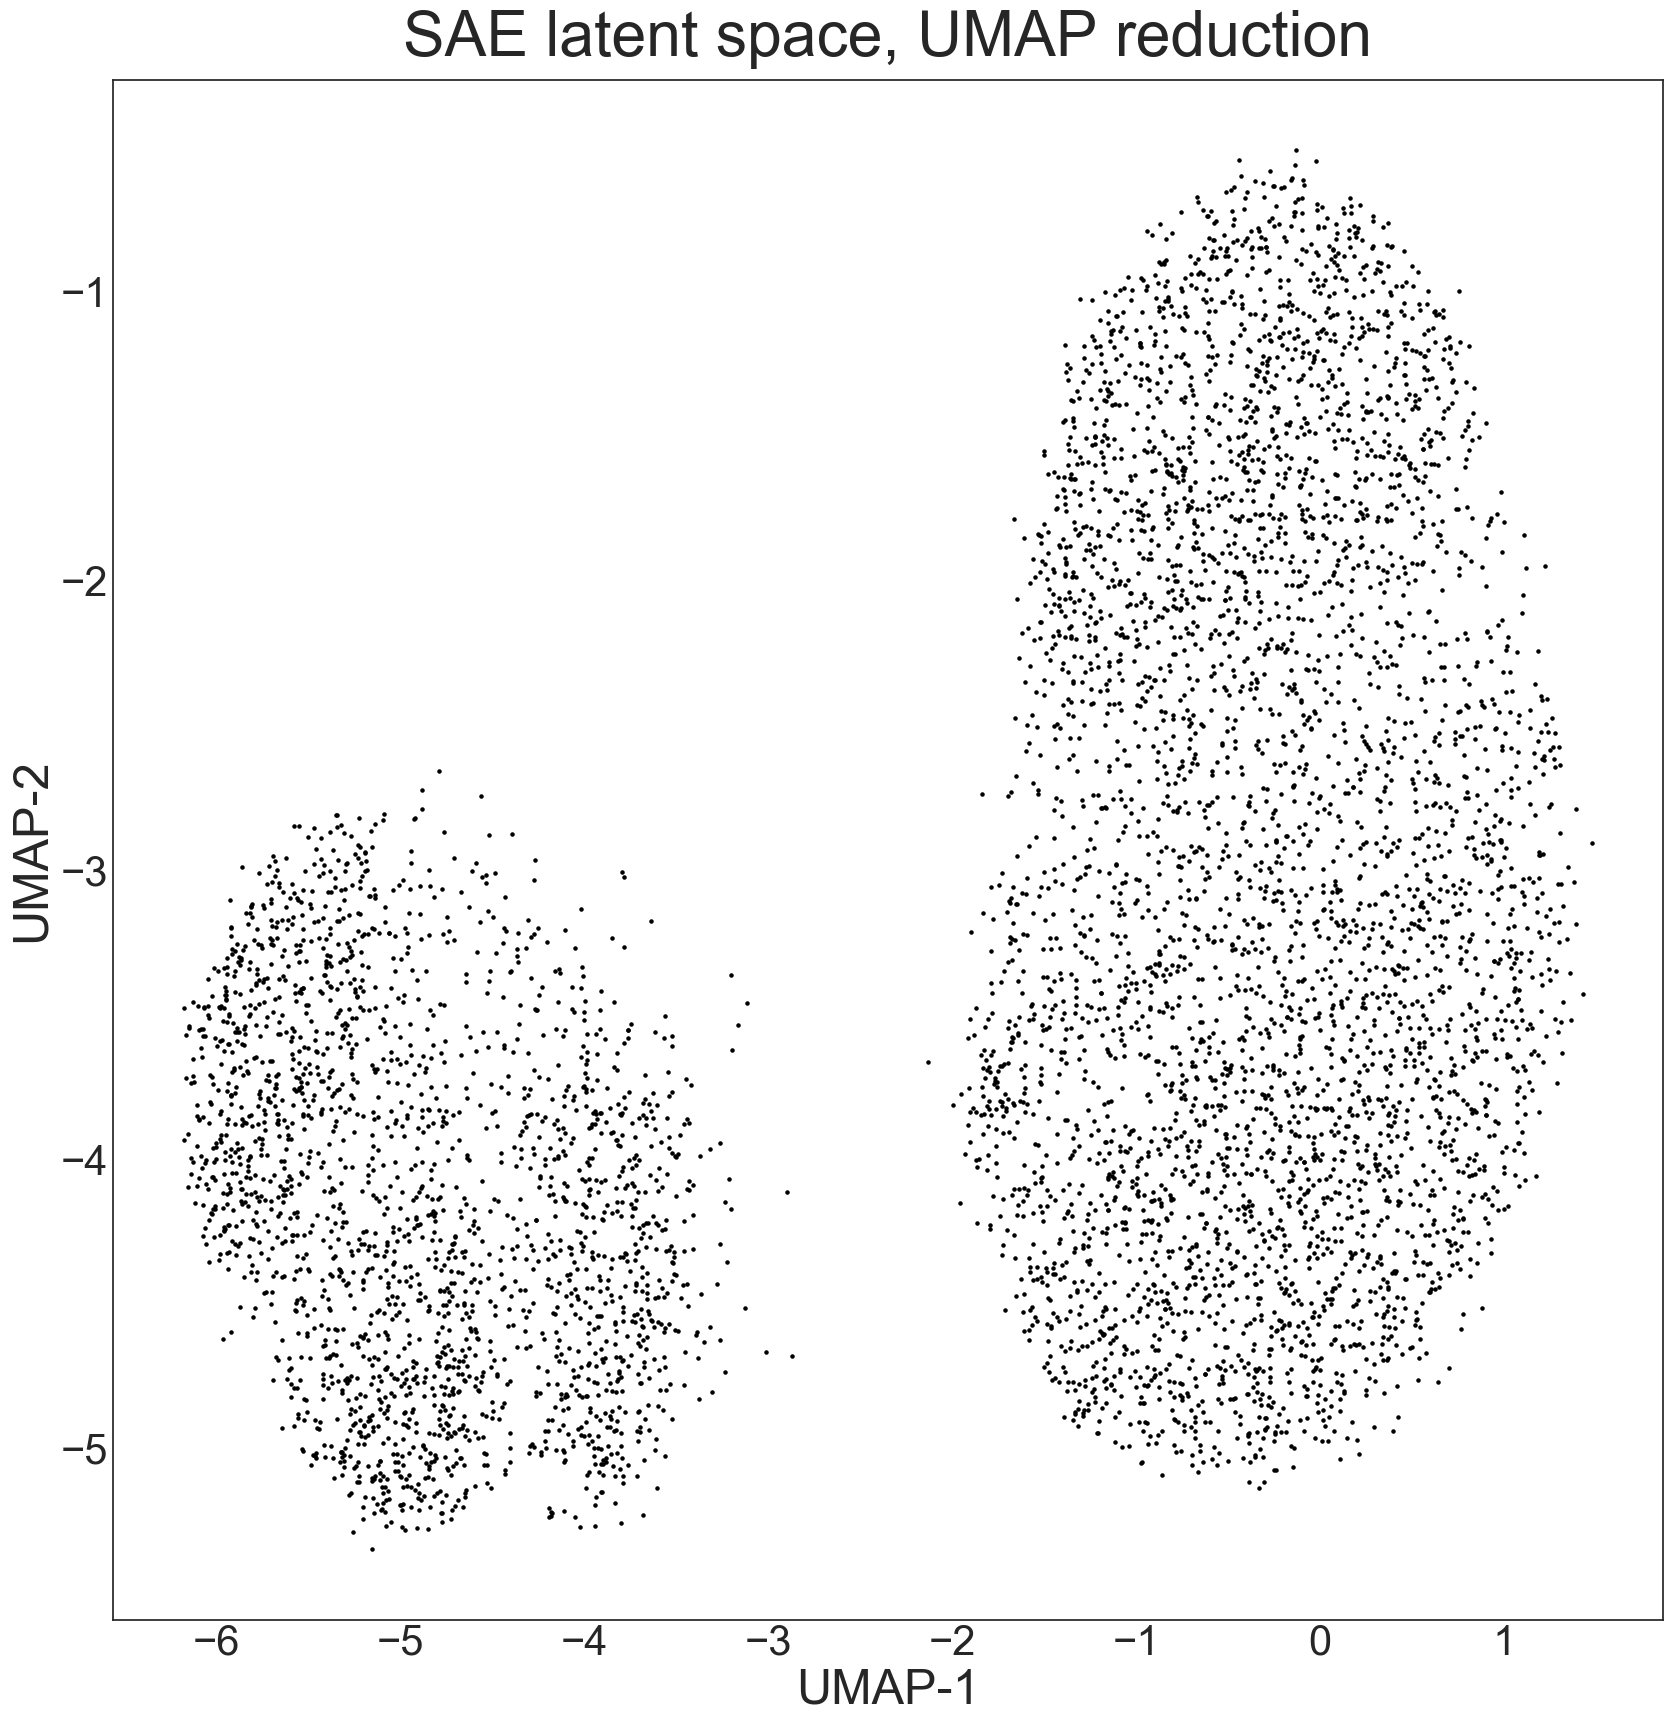

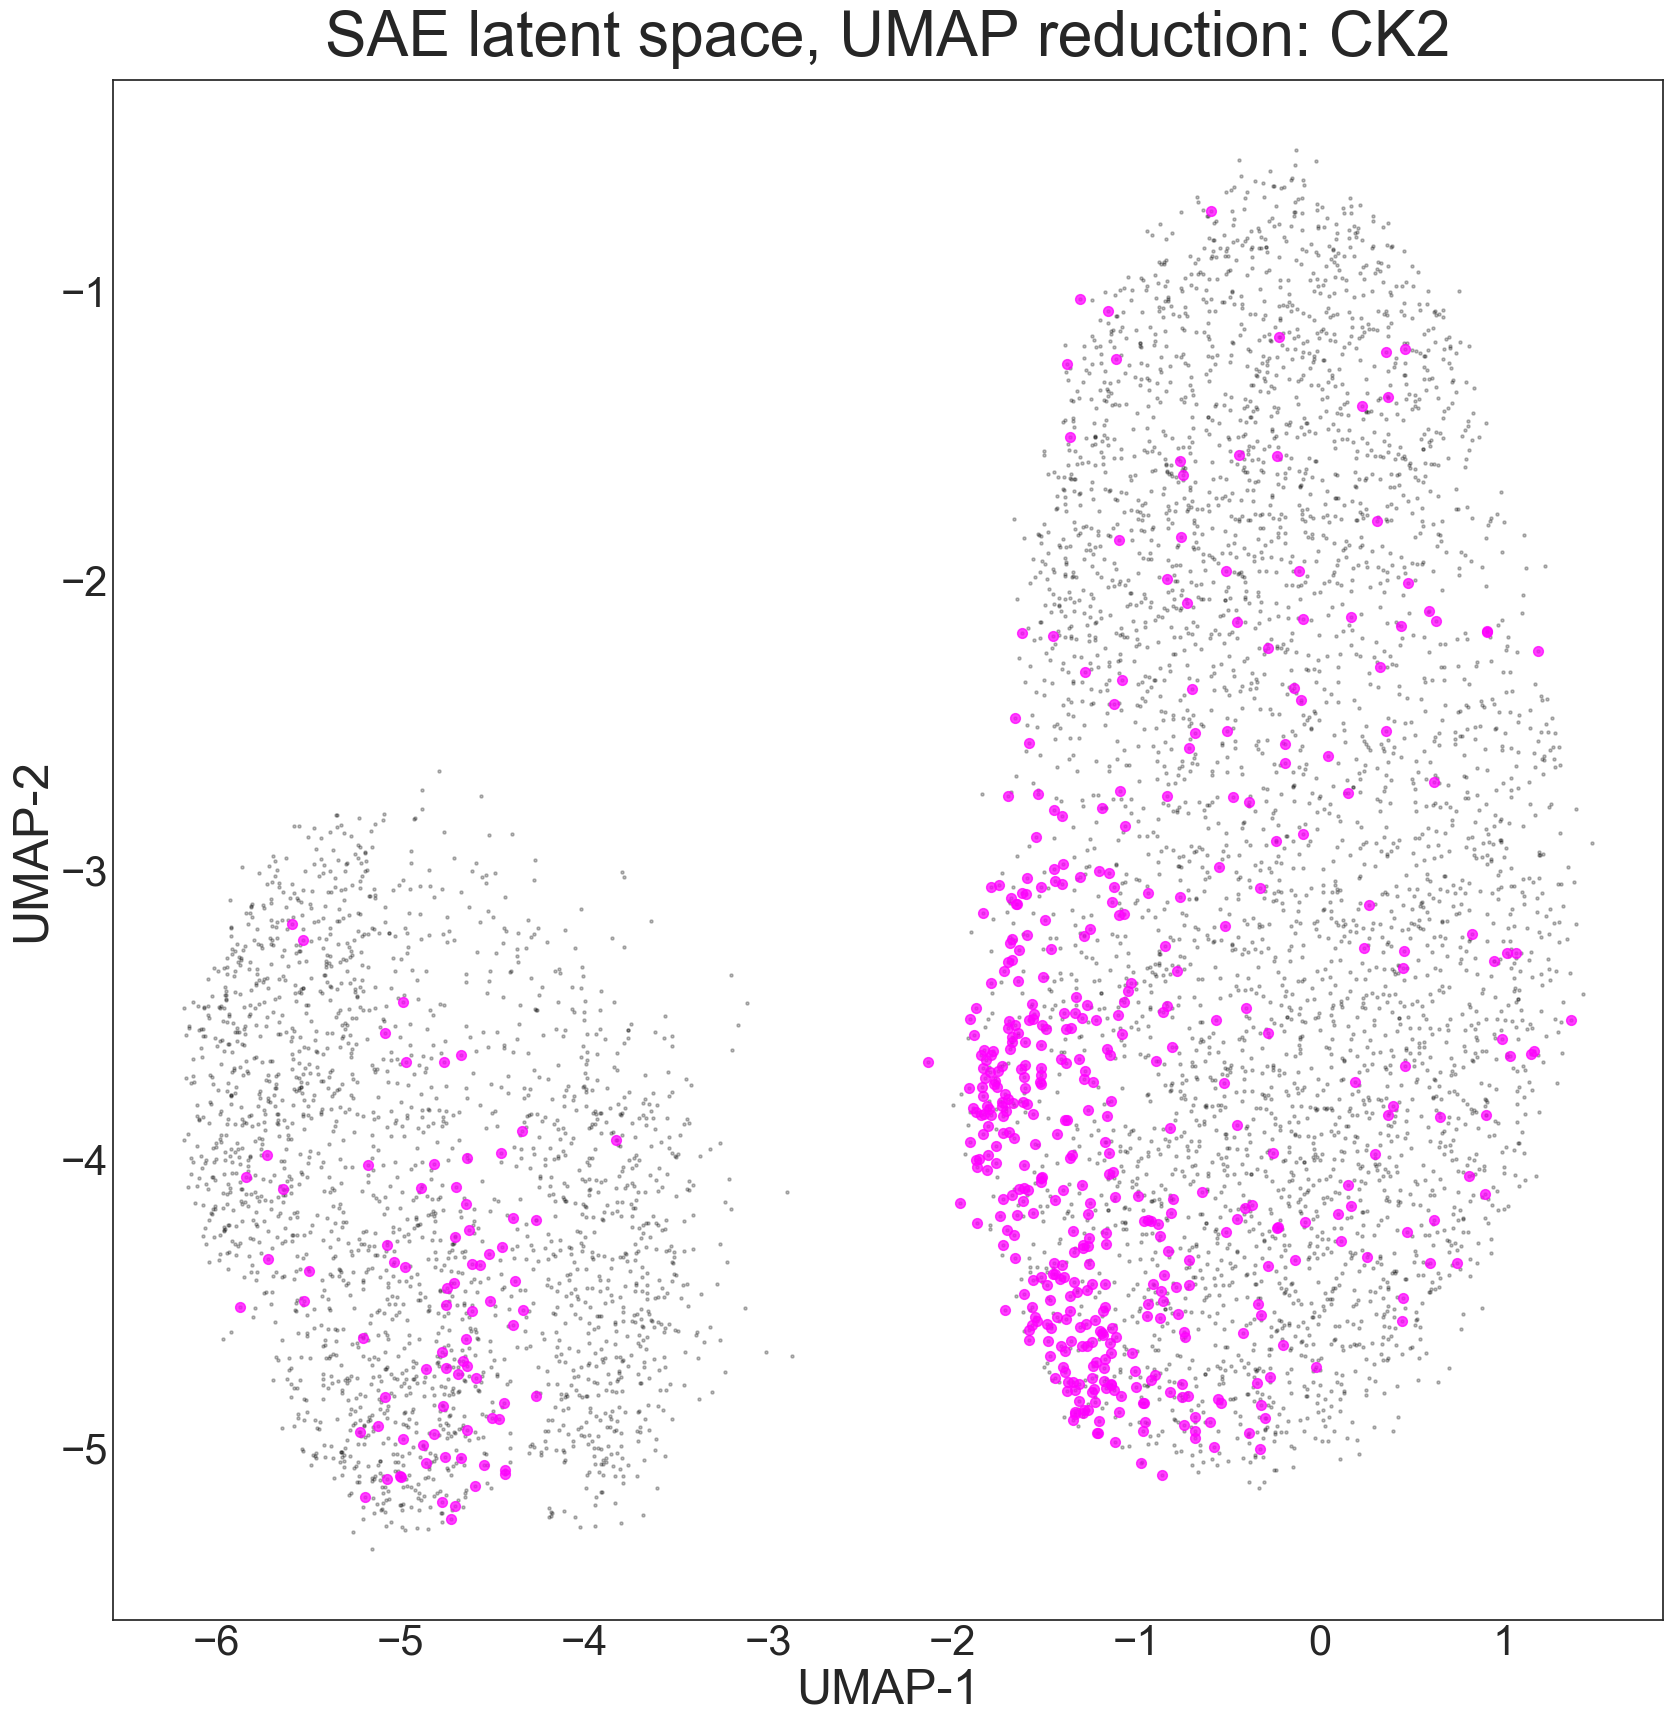

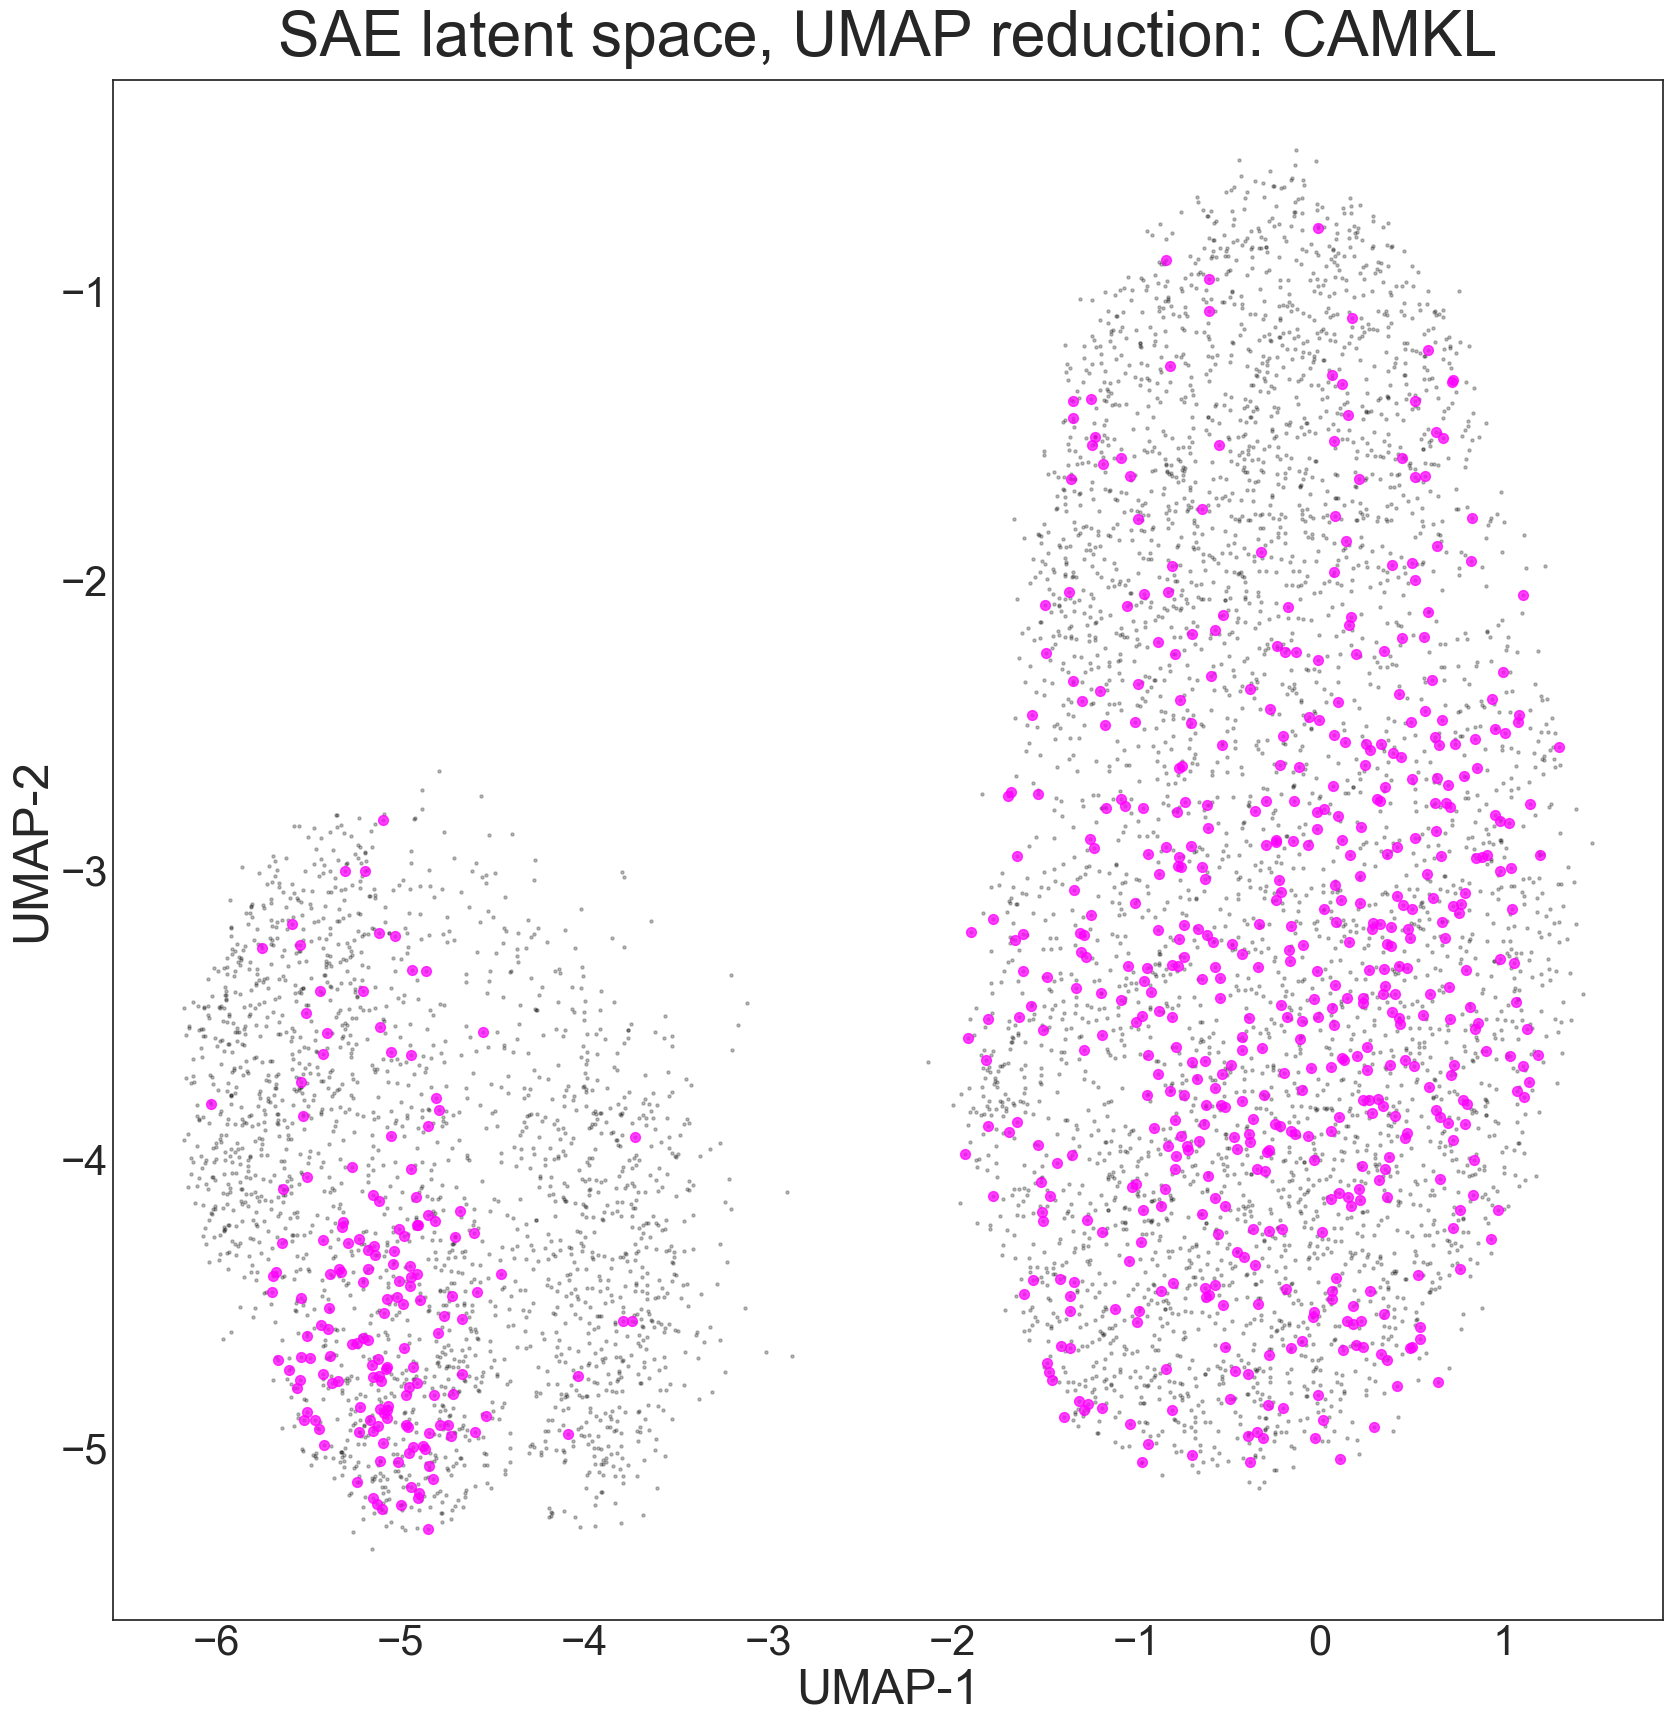

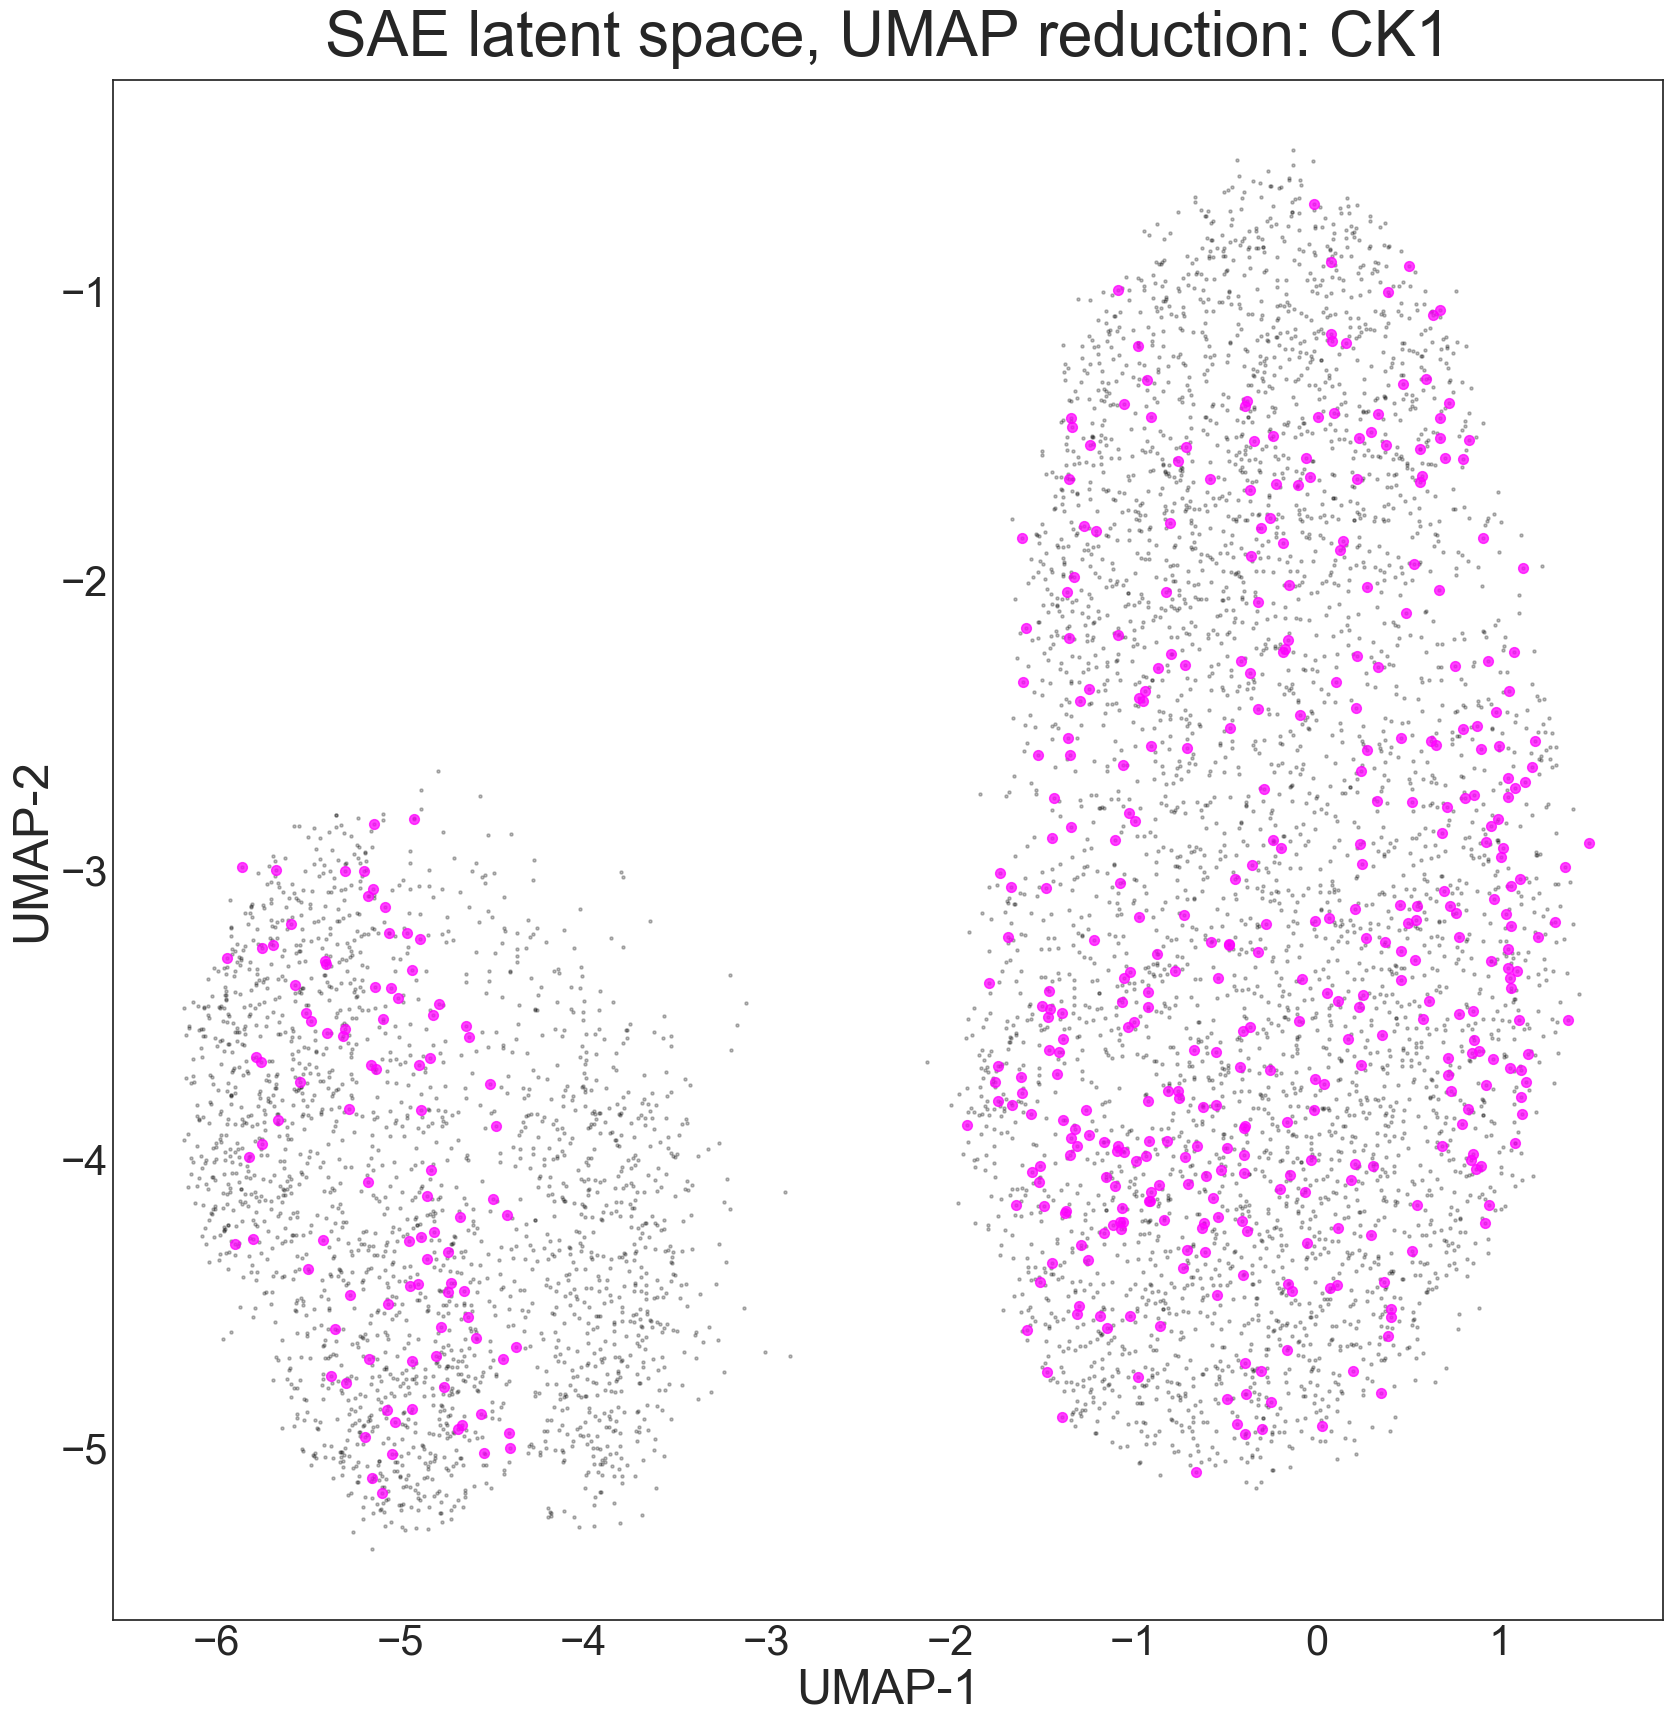

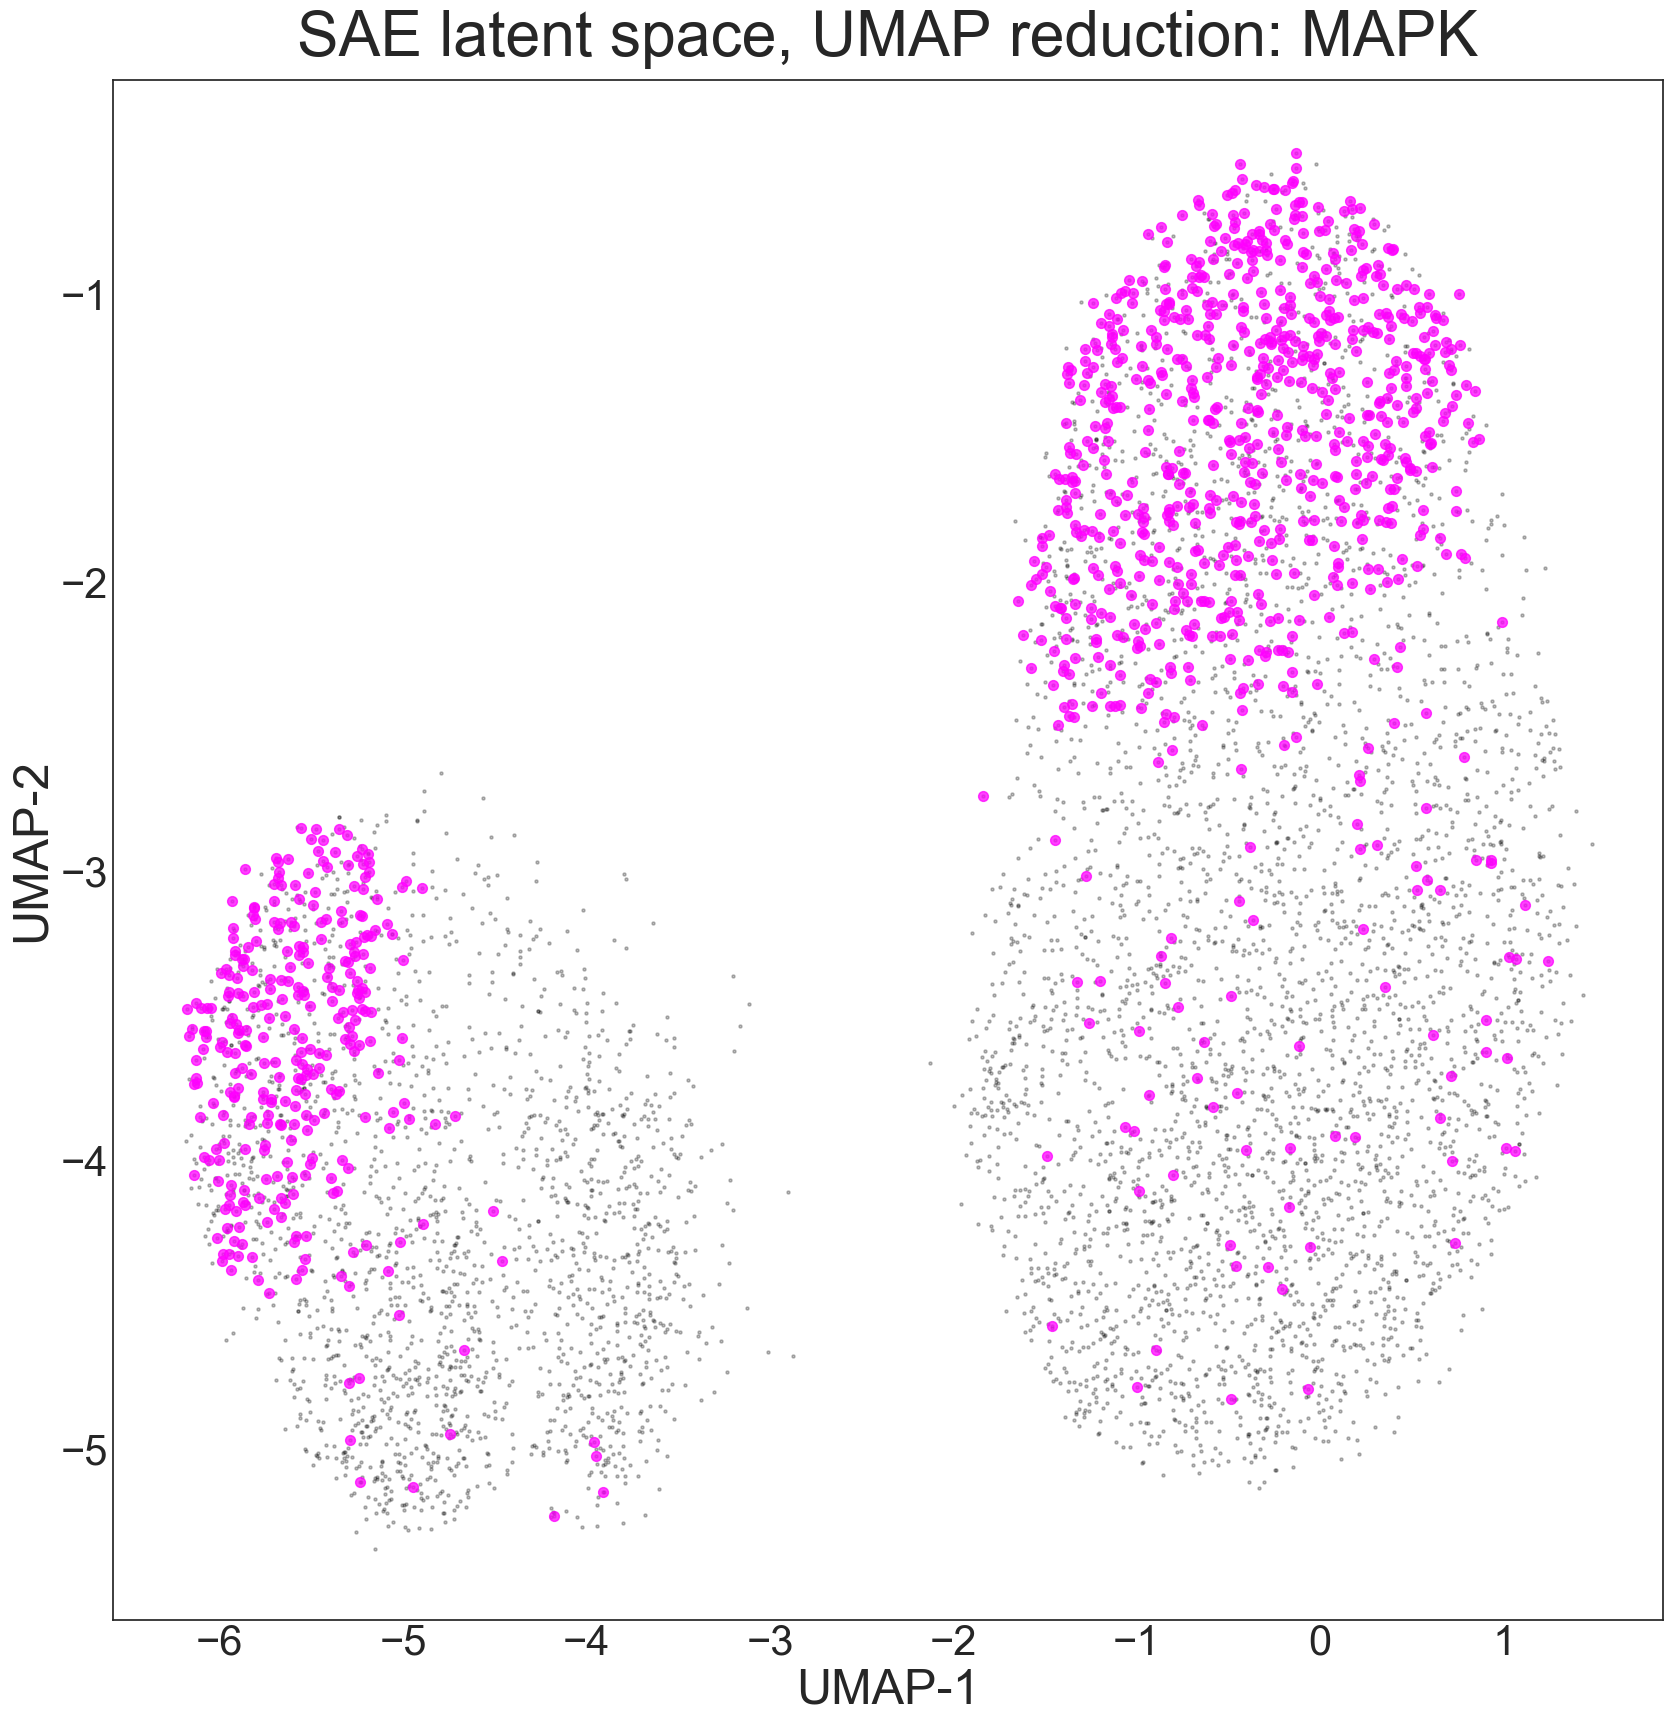

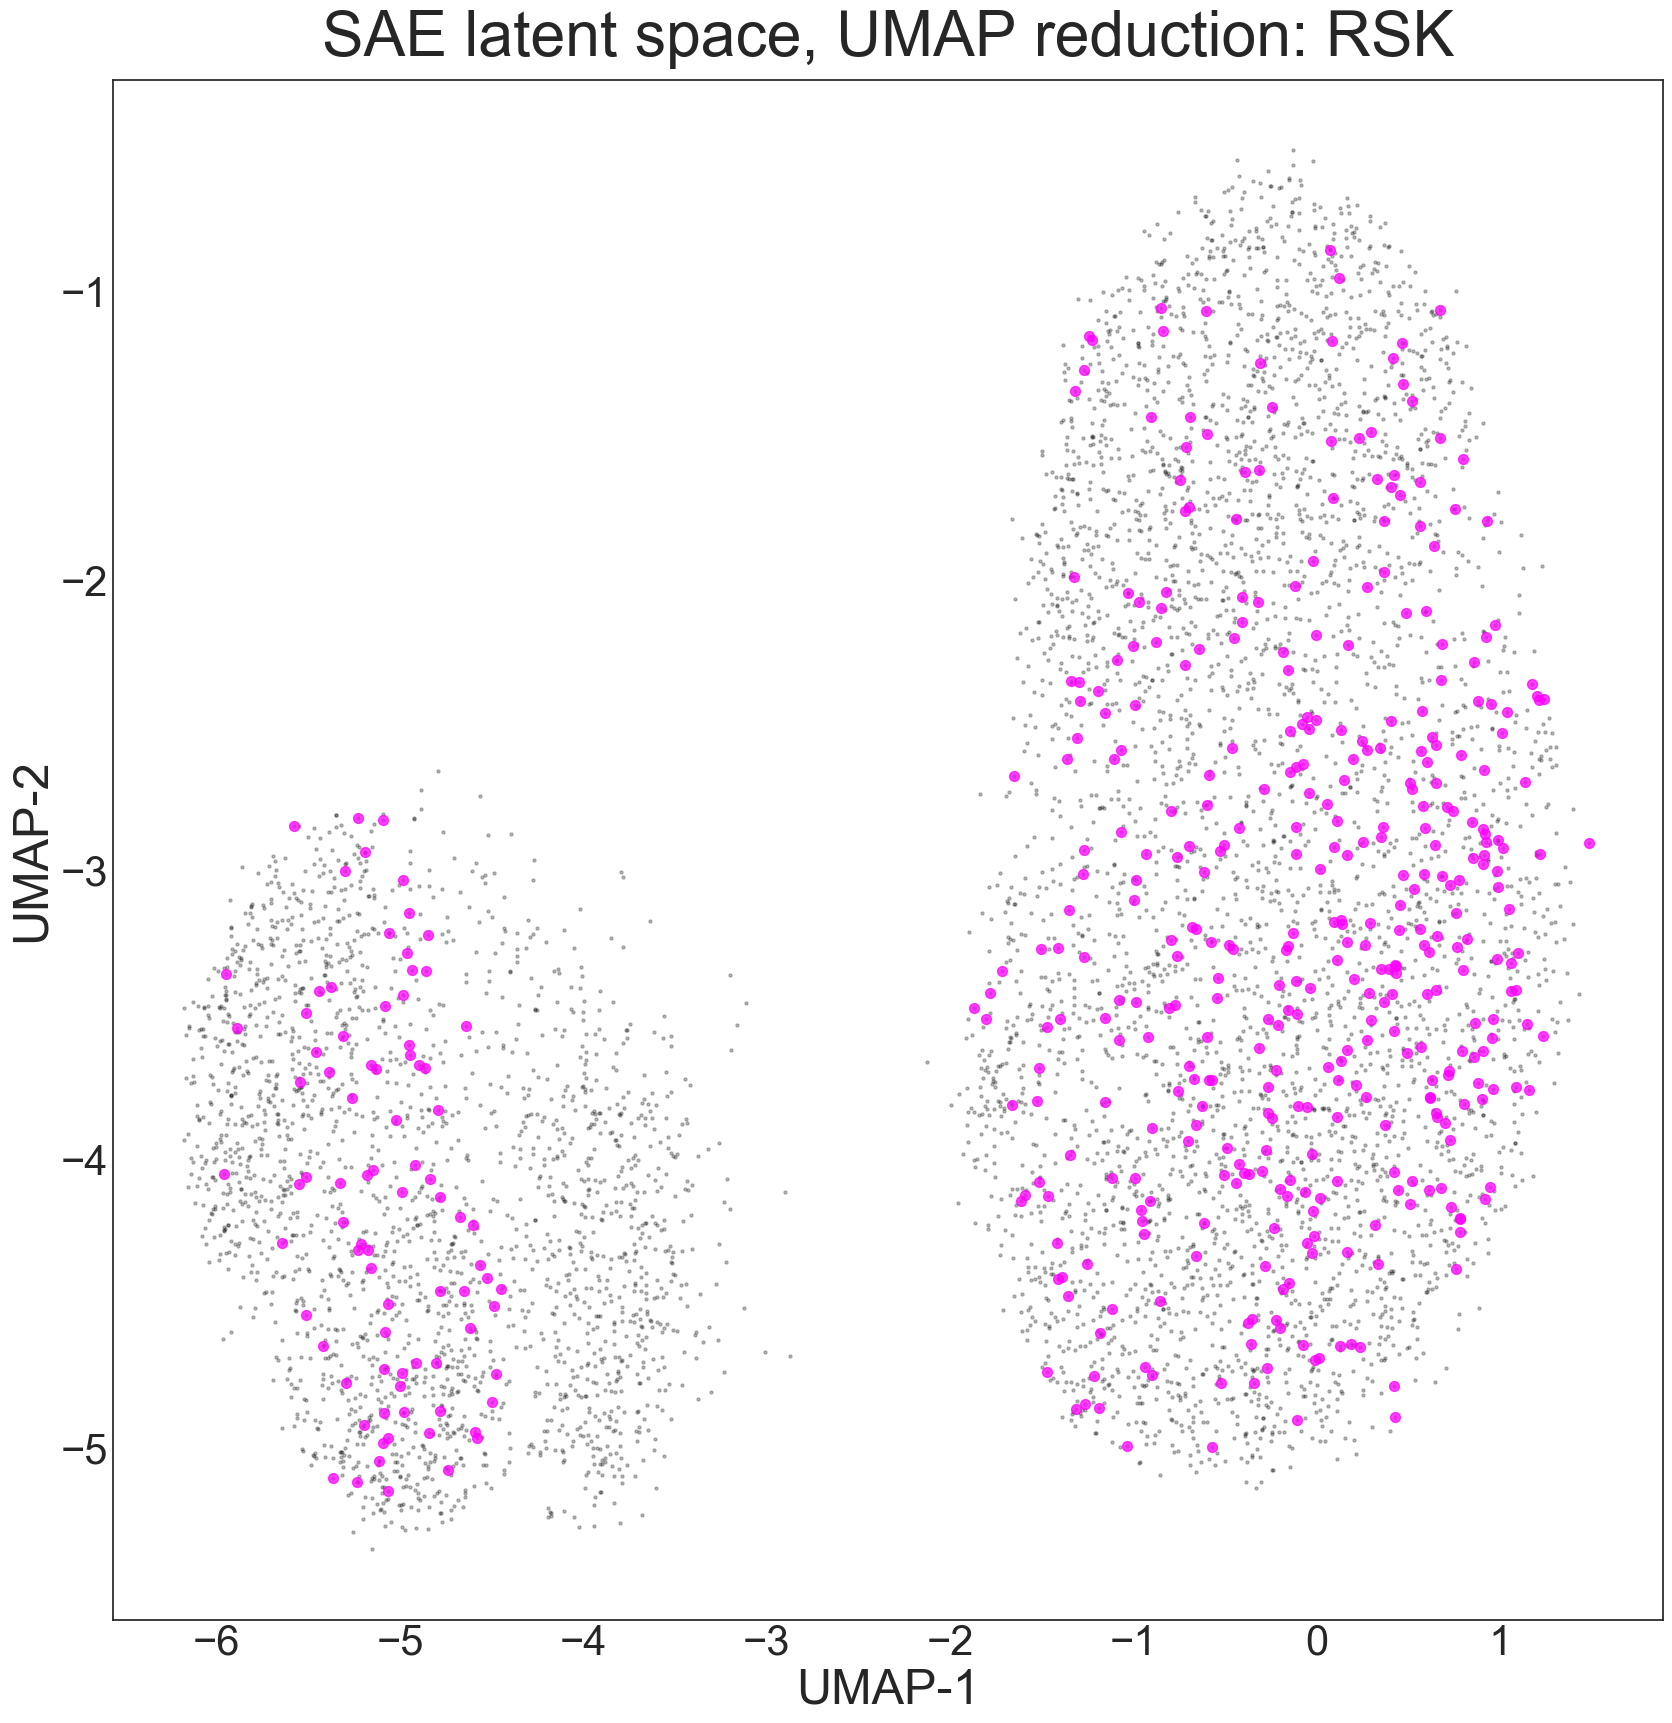

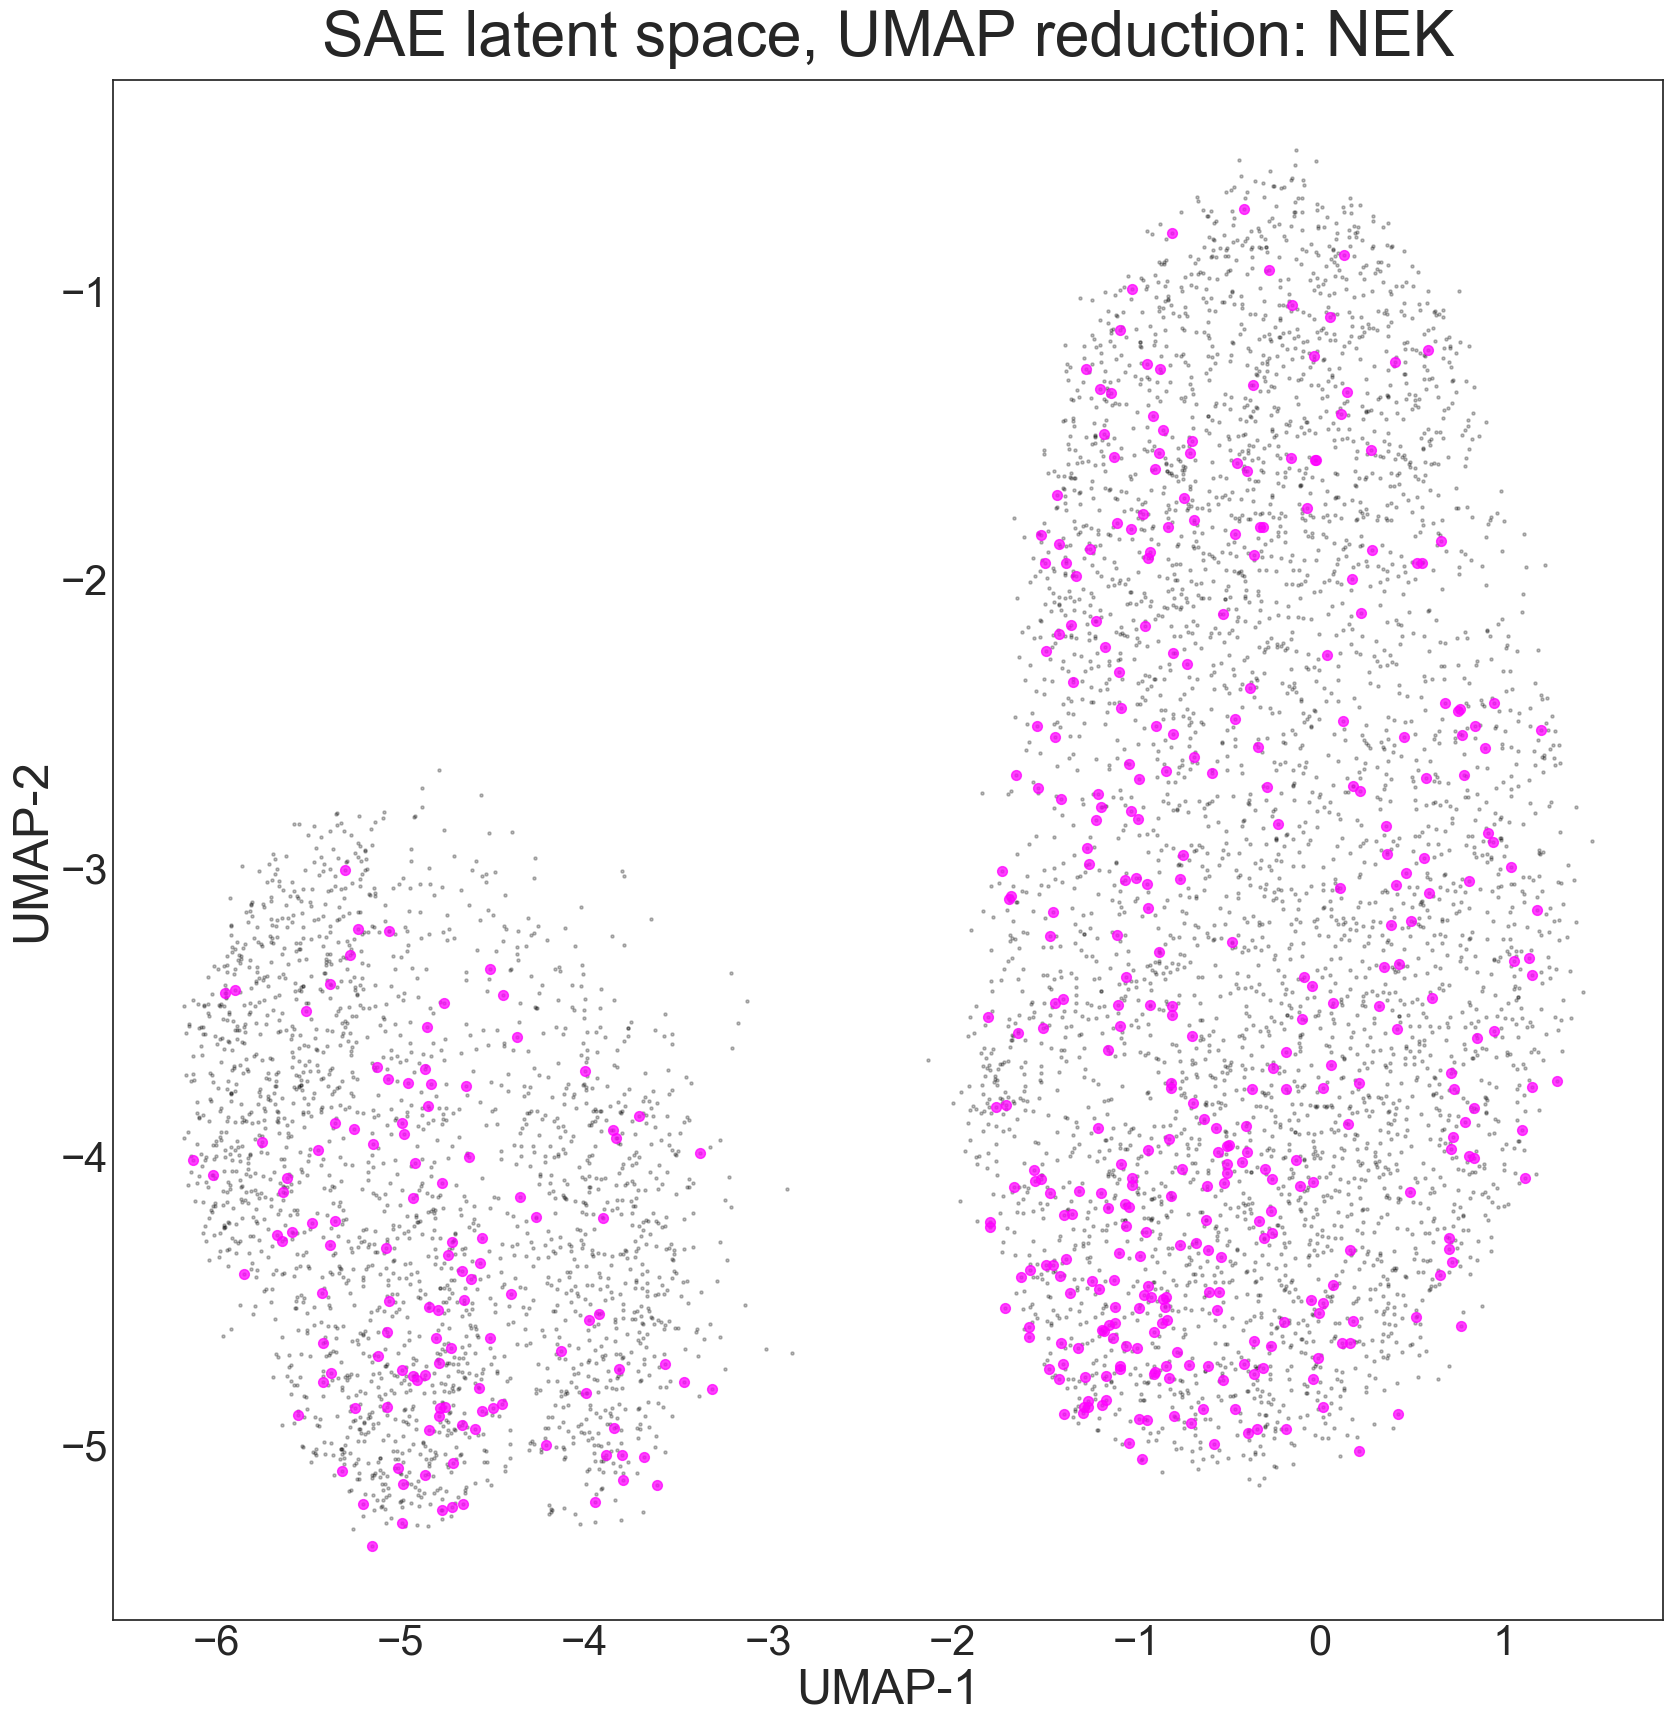

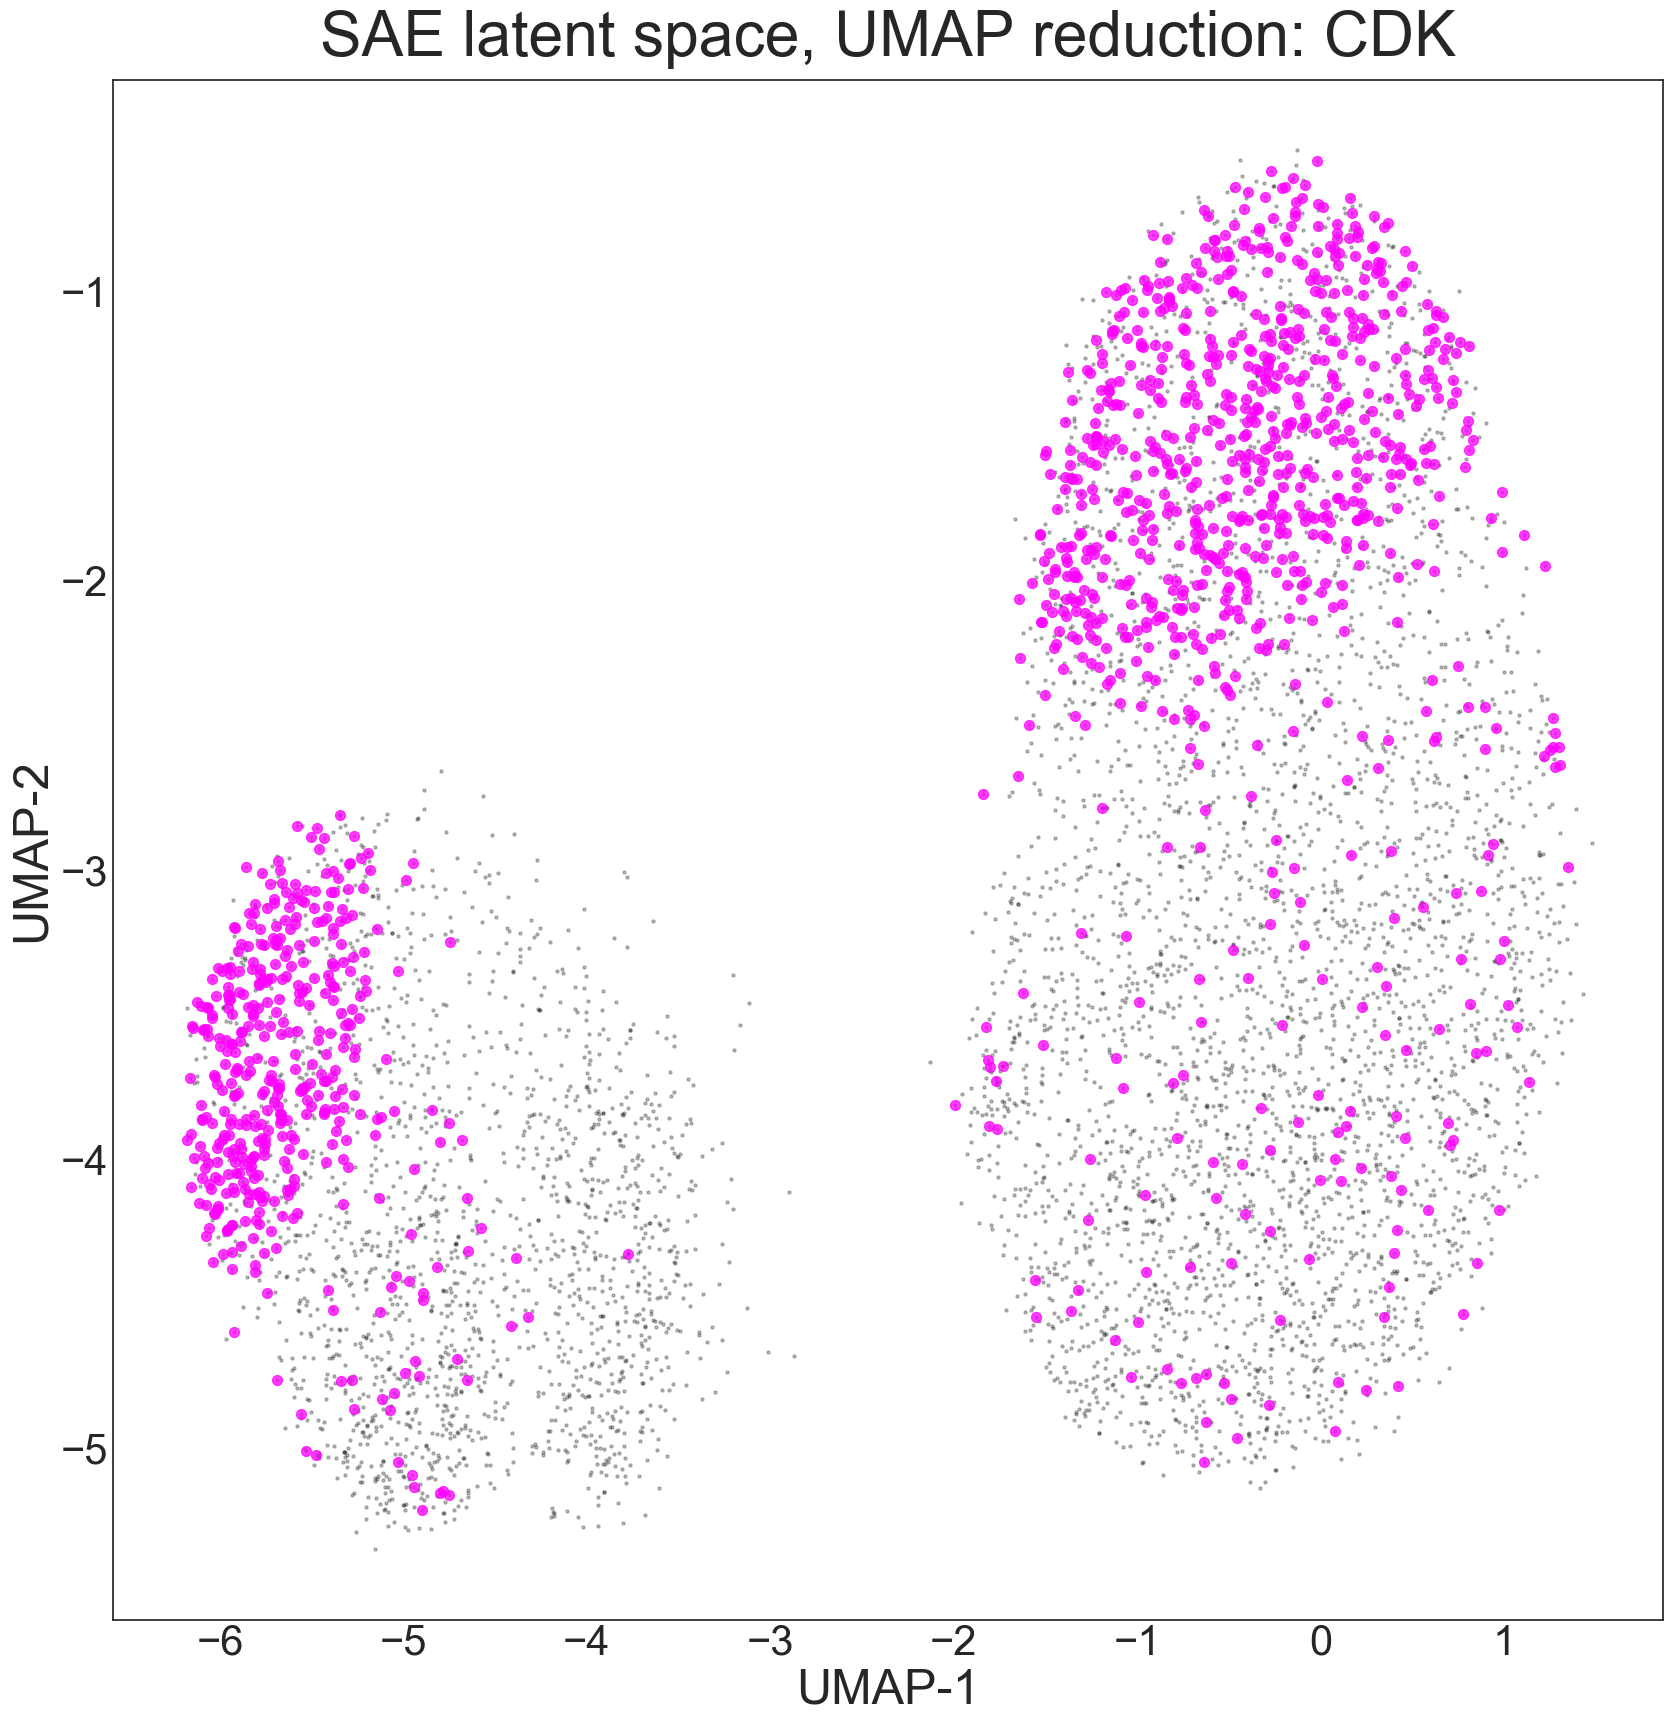

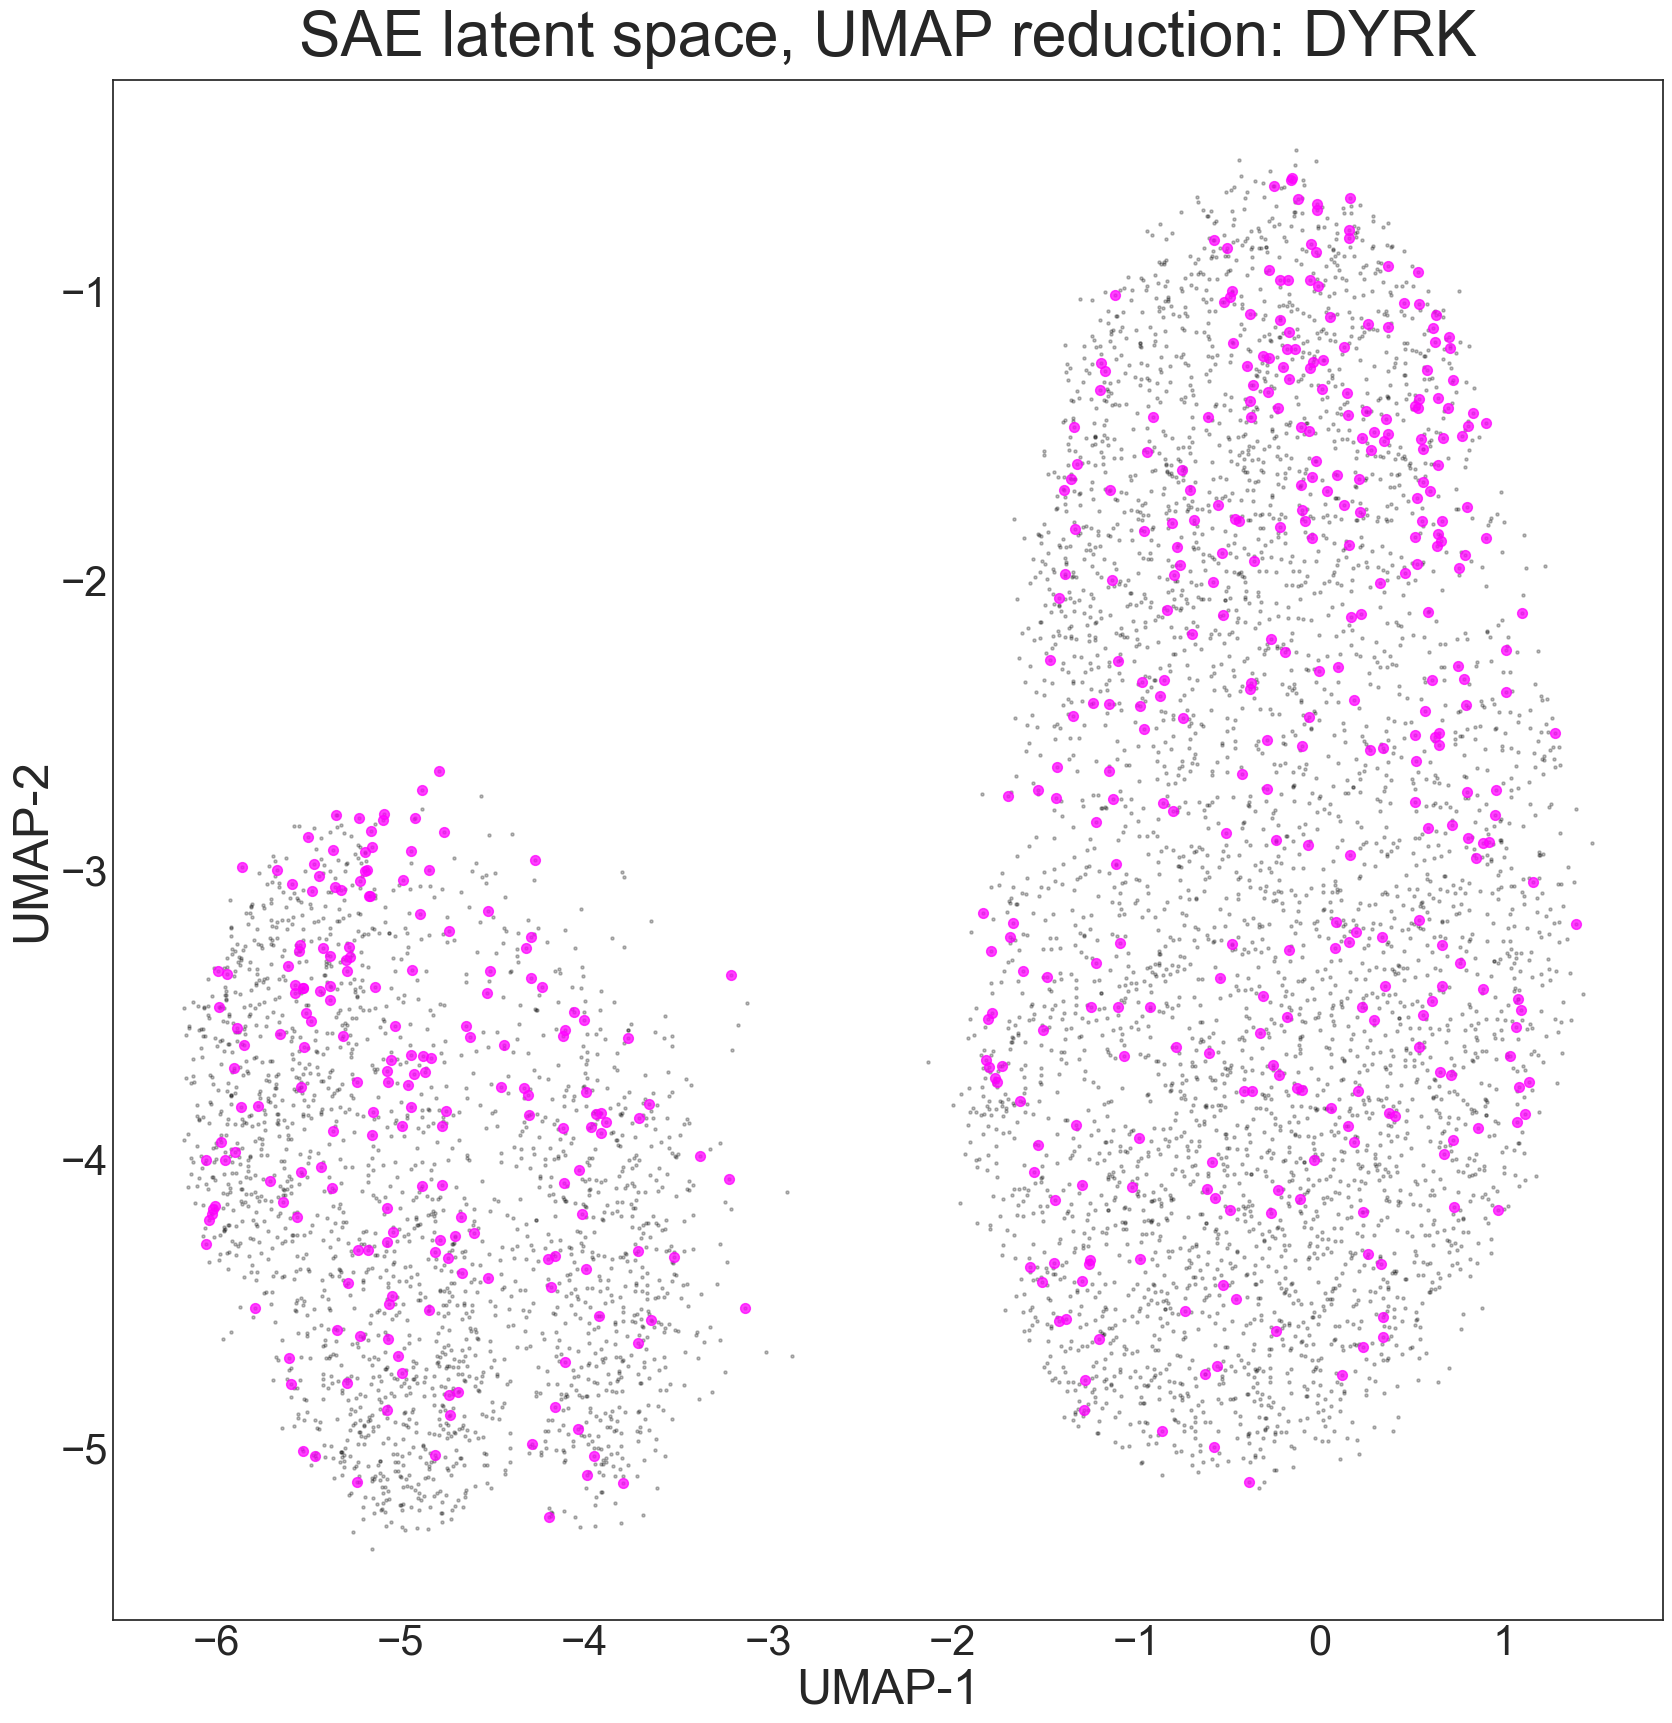

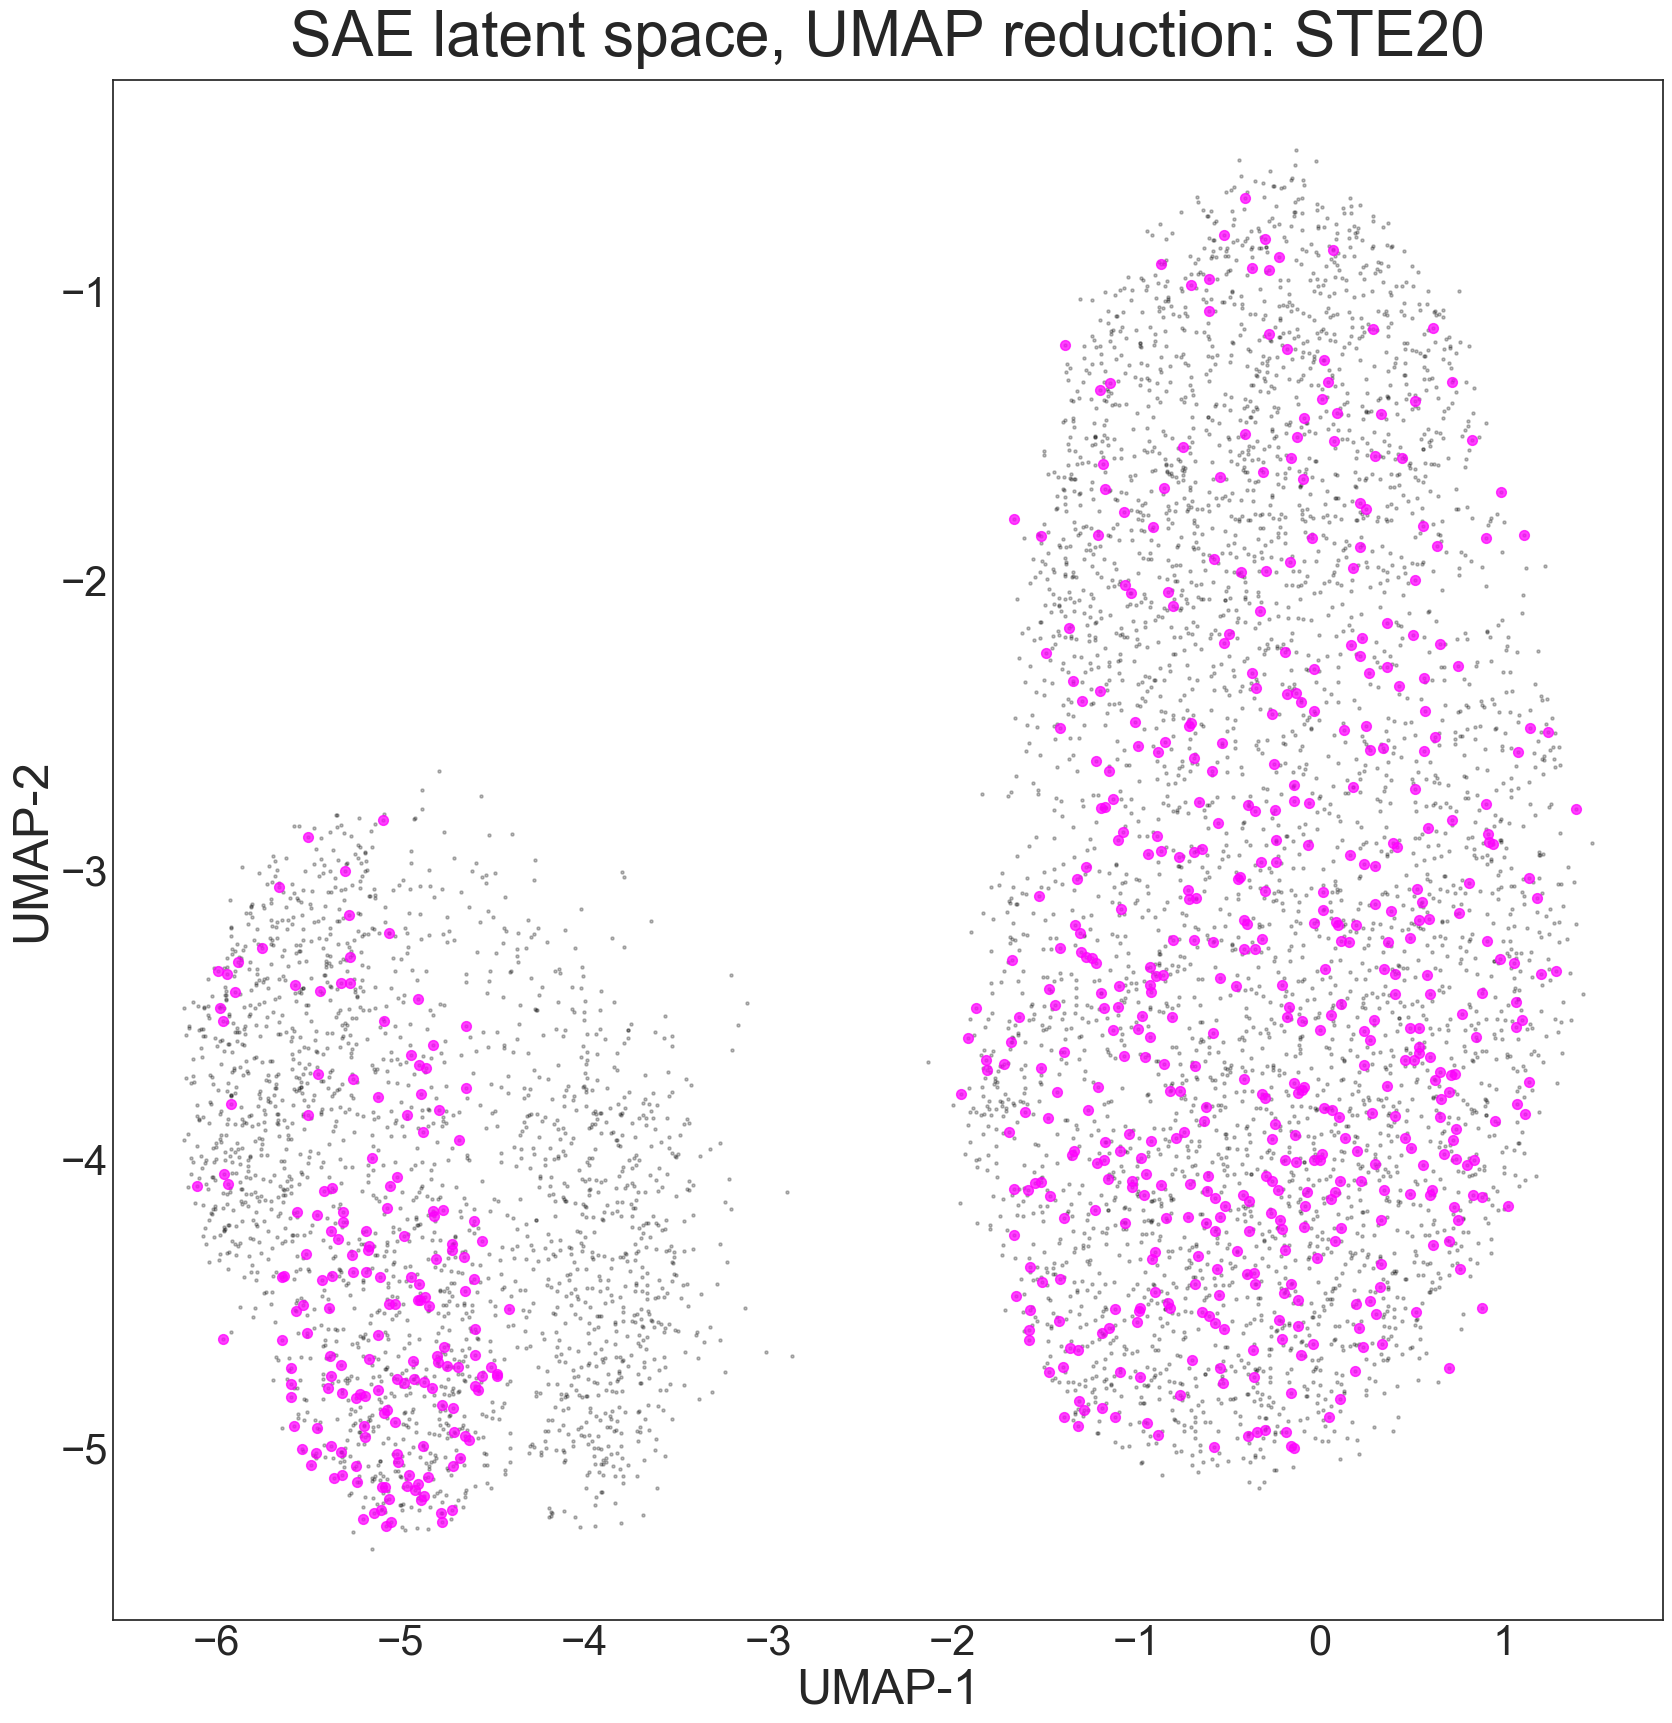

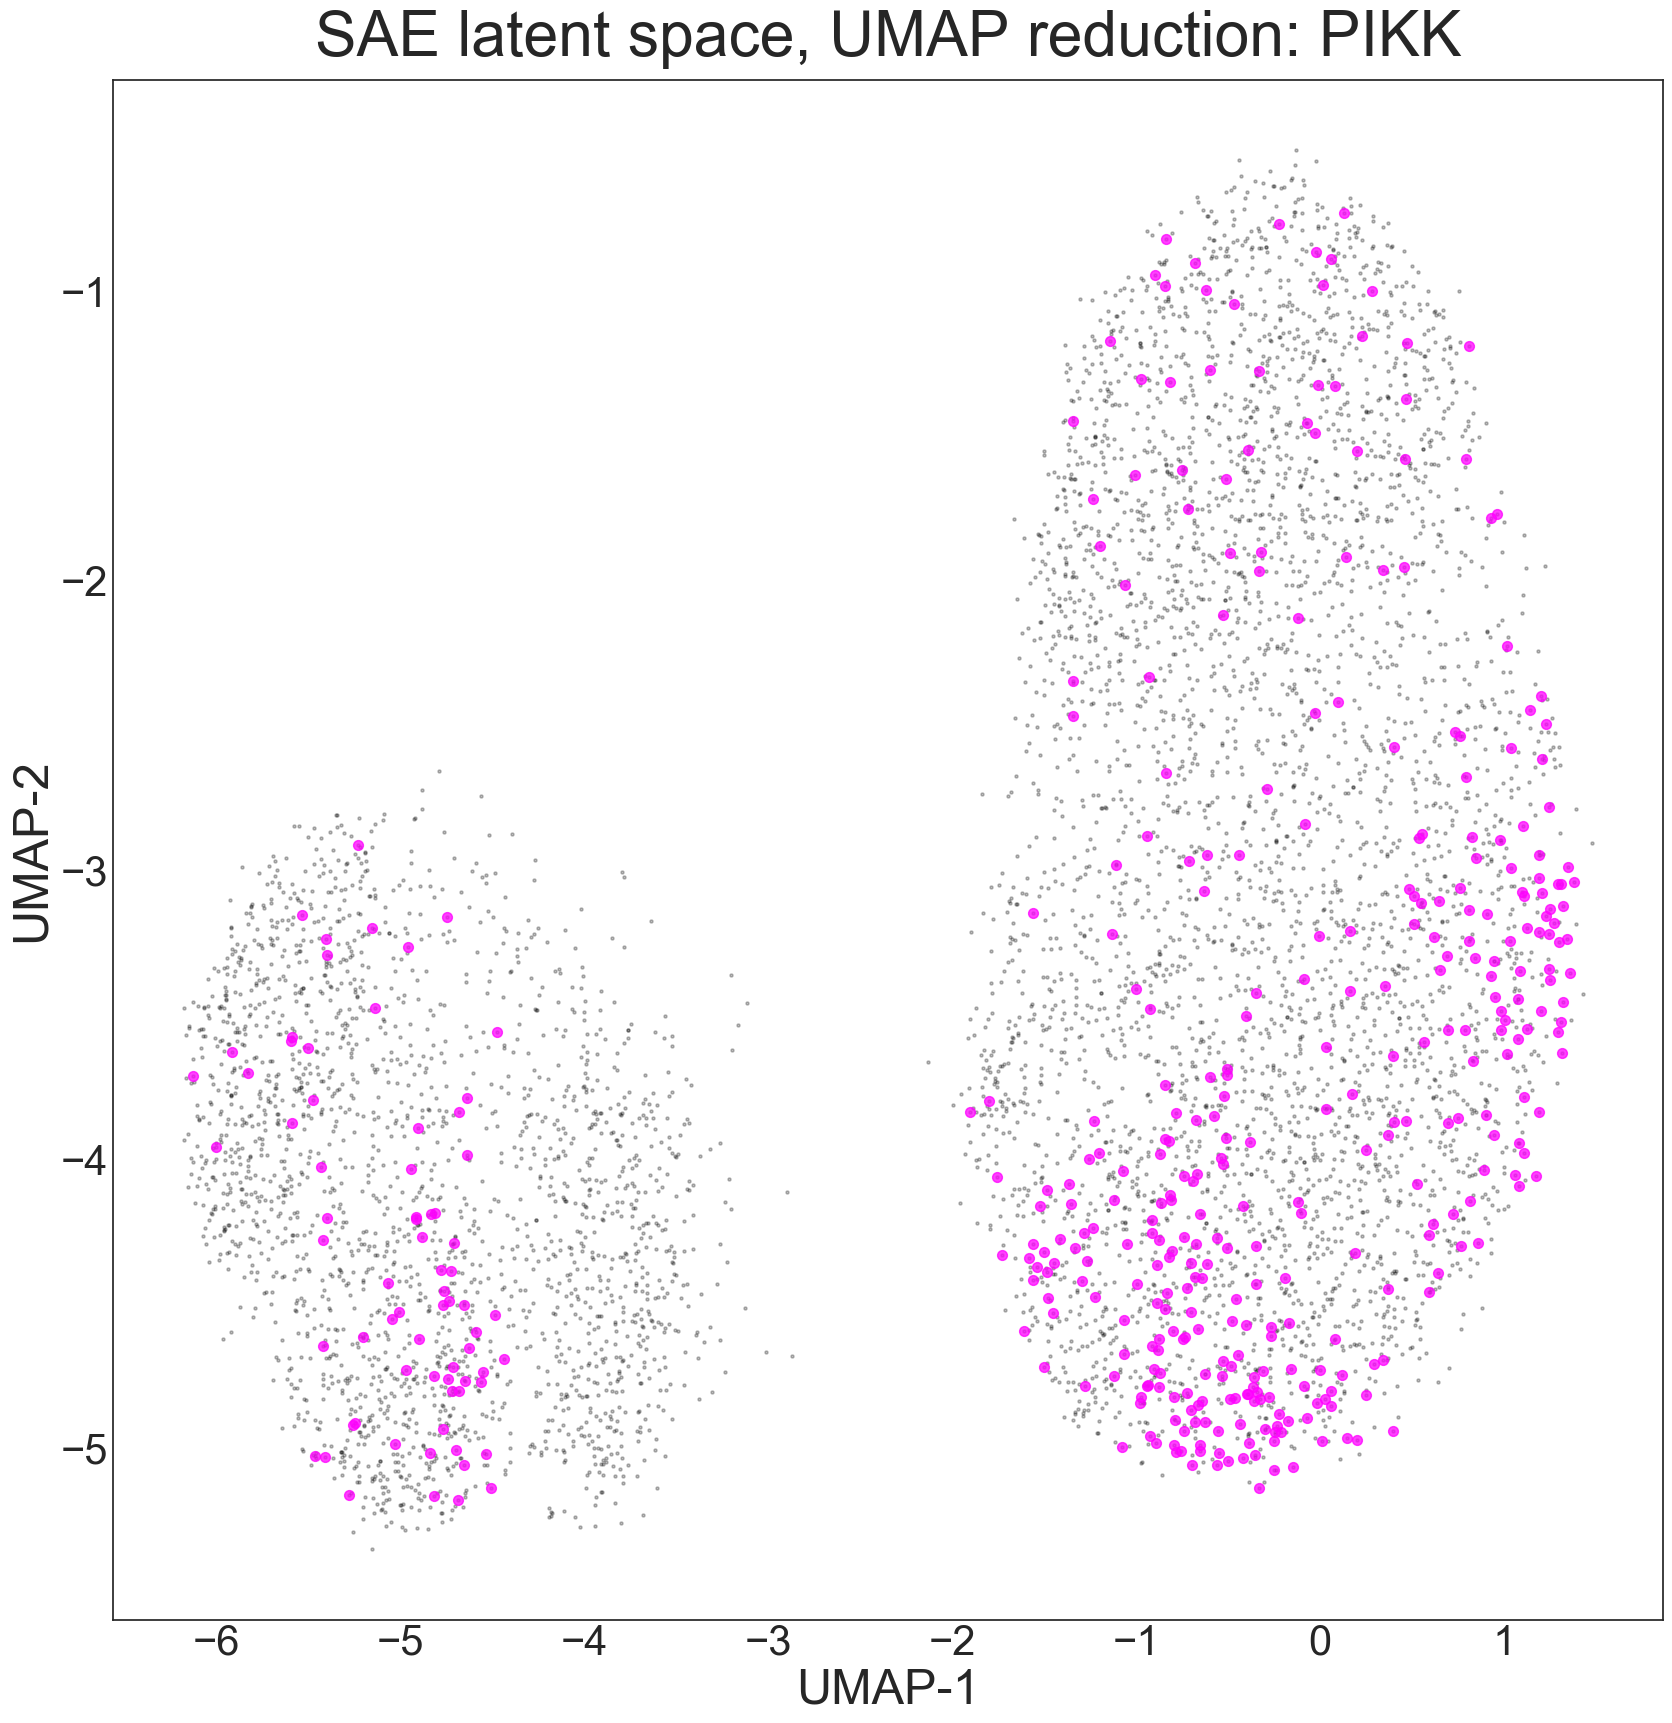

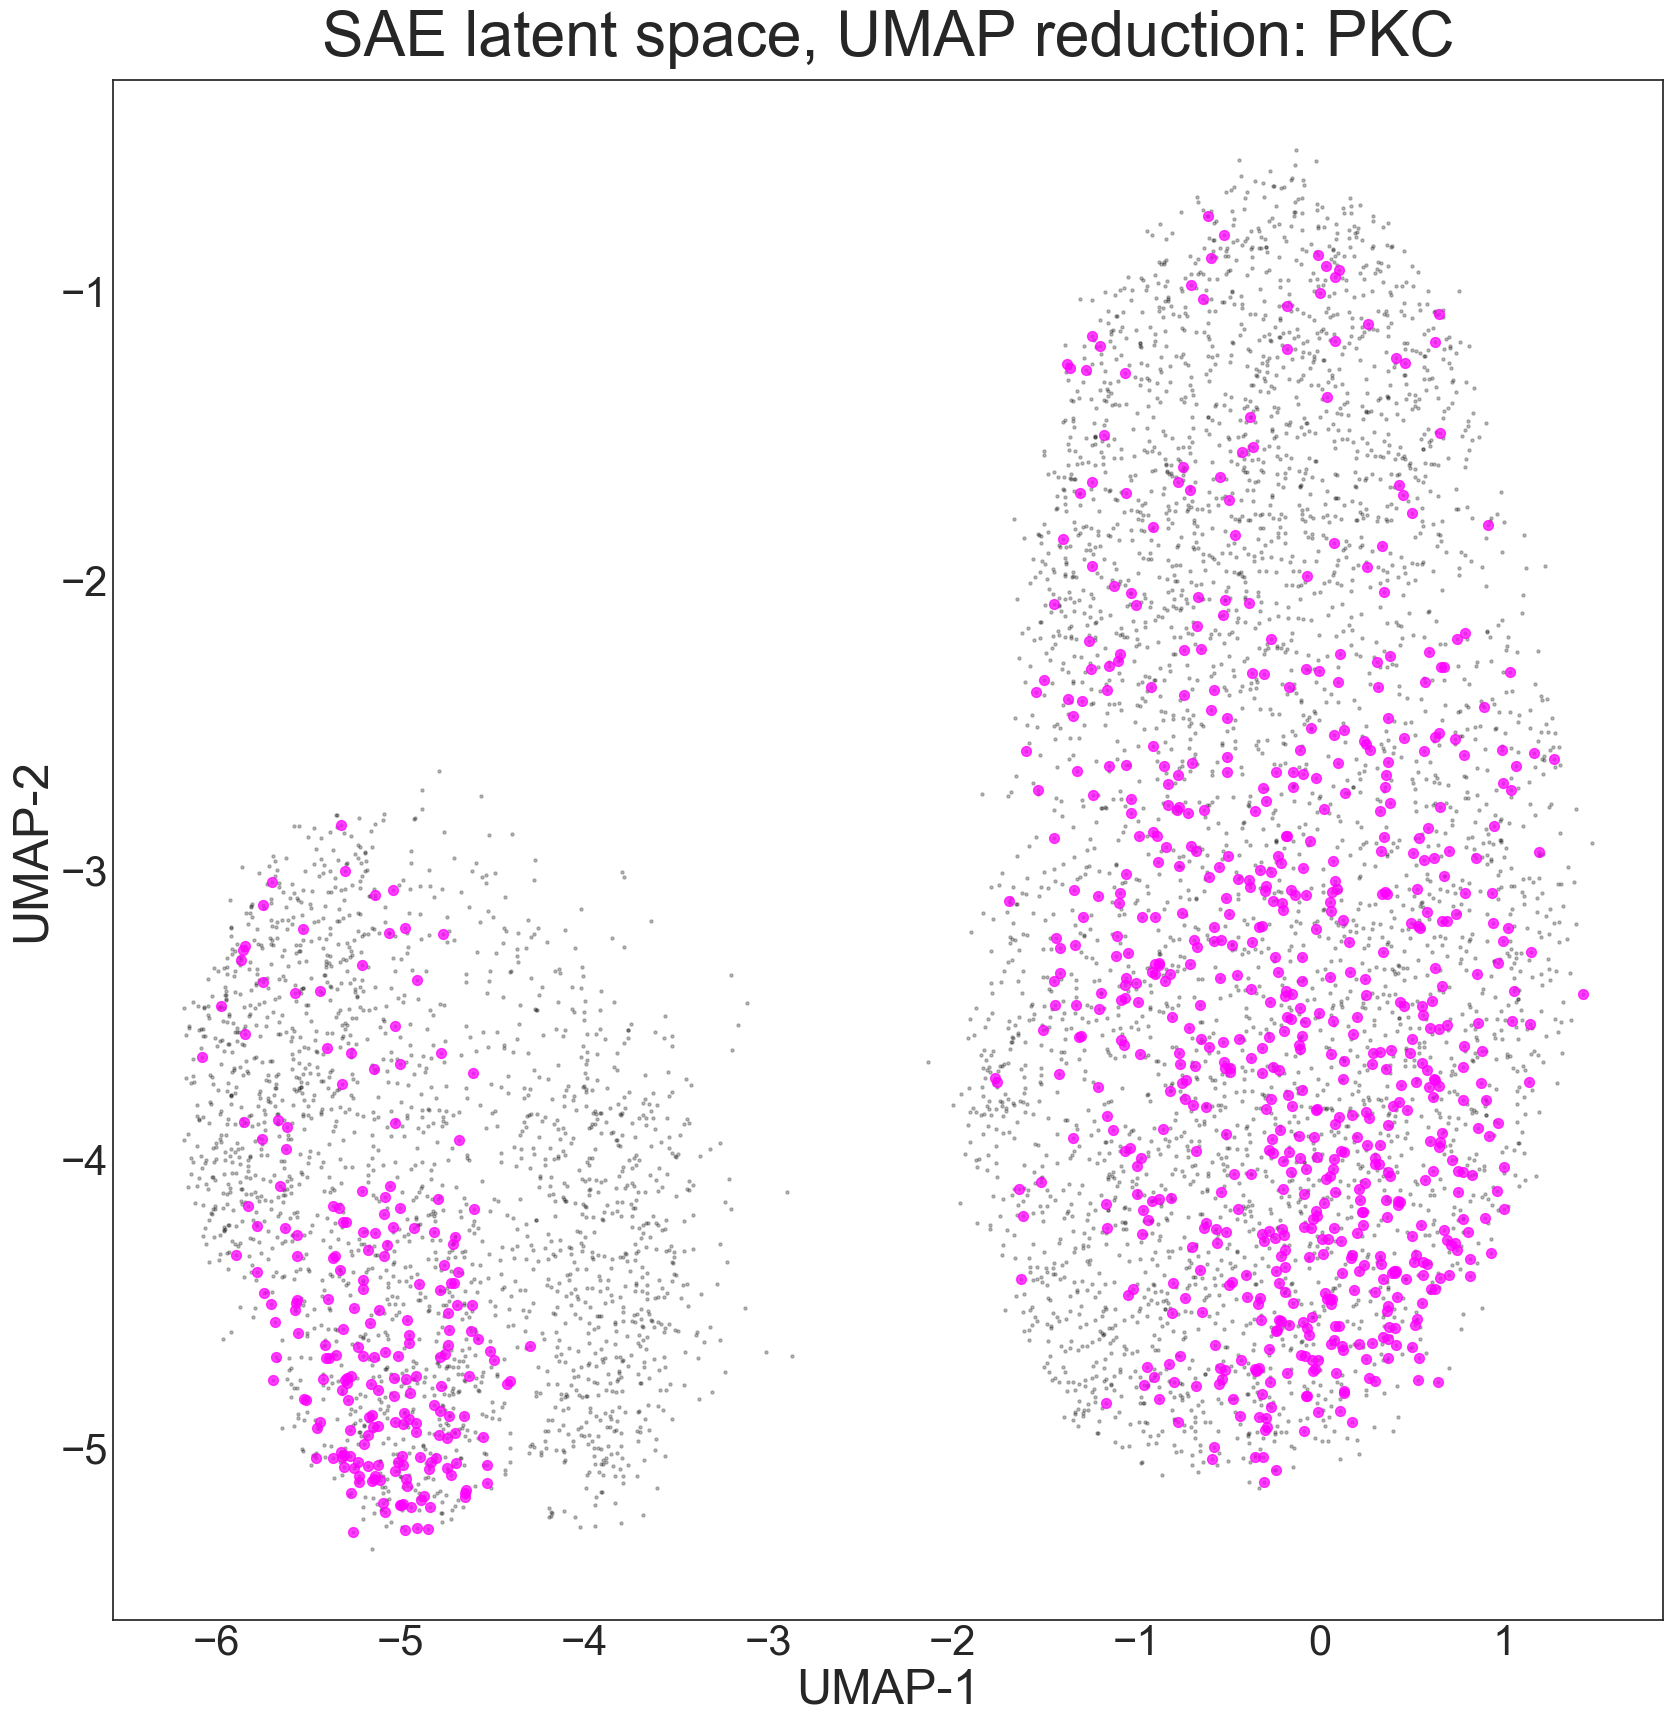

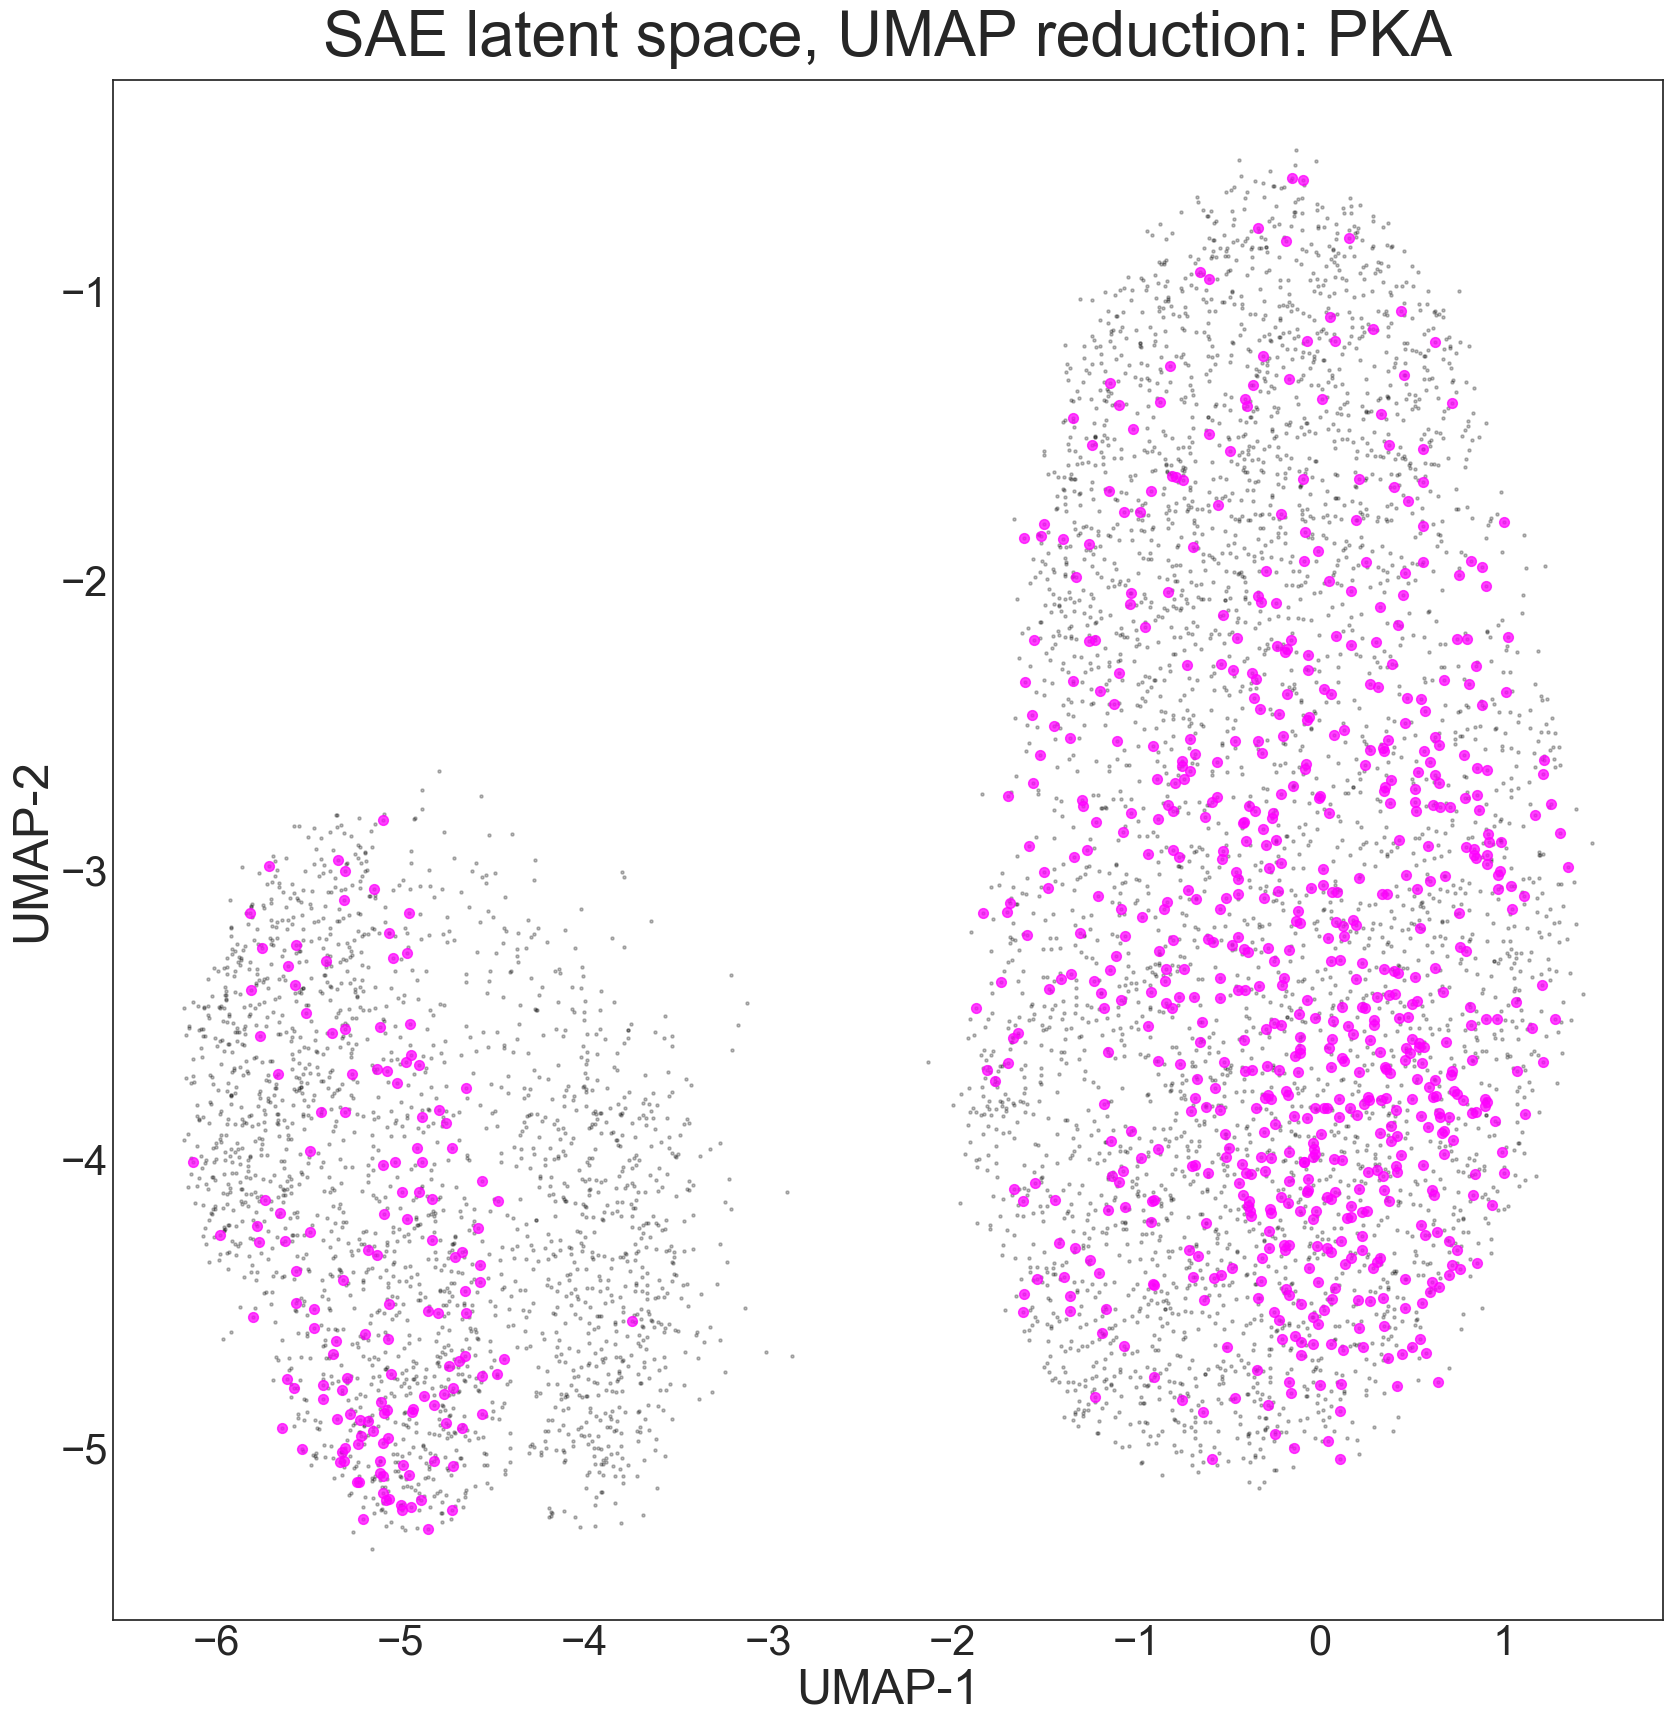

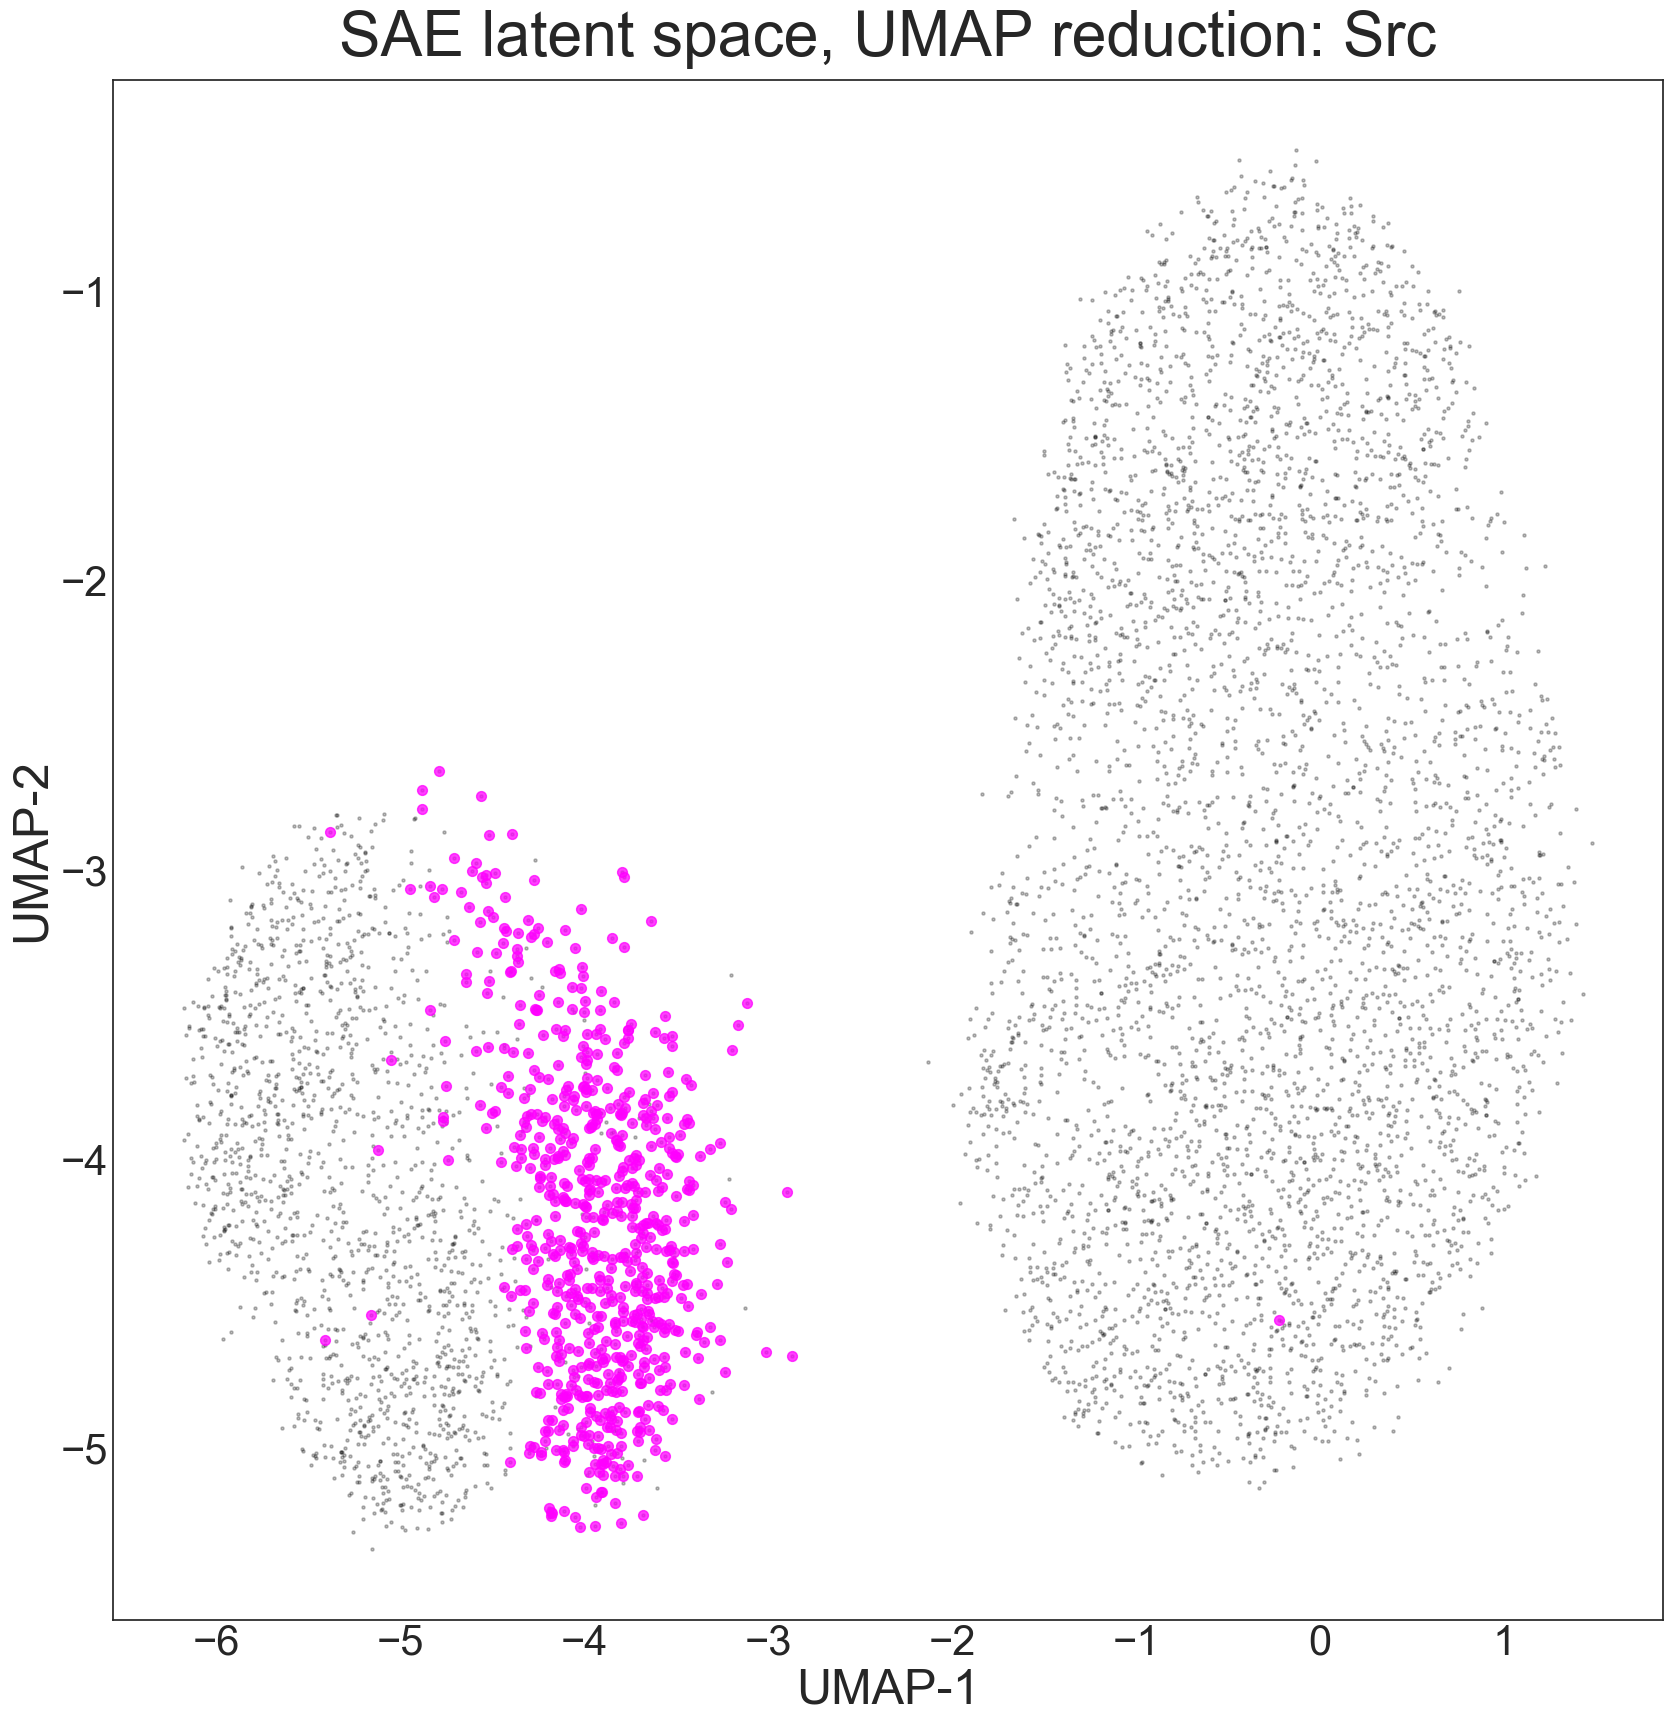

In [60]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

# colors = ['red','coral','sandybrown','orange','gold','lawngreen','limegreen','turquoise','deepskyblue','blue','blueviolet','violet','deeppink','crimson','mediumslateblue','brown']
colors = ['magenta']
colors = ['red', '#9B30FF', 'green', 'blue', 'magenta']

plt.figure(figsize=(20,20))
plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black', alpha=1) #alpha=0.25)

plt.title("SAE latent space, UMAP reduction",fontsize=45,y=1.01)
plt.xlabel("UMAP-1",fontsize=35)

plt.ylabel("UMAP-2",fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.savefig("vaeFave/noHighlights")
plt.show()

i = -1
for fam in fams:
    i+=1
    fIdx = numpy.where(fams==fam)[0][0]
    plt.figure(figsize=(20,20))
    plt.title(("SAE latent space, UMAP reduction: %s" % fam),fontsize=45,y=1.01)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel("UMAP-1",fontsize=35)

    plt.ylabel("UMAP-2",fontsize=35)
    plt.scatter(pos_umap[:, 0], pos_umap[:, 1], marker = 'o',s=5,color='black',alpha=0.25)
    color = colors [4]
    for motifIdx, (x, y) in enumerate(zip(pos_umap[:, 0], pos_umap[:, 1])):
        if motifxFamMatrix[motifIdx][fIdx]==1:
            plt.scatter(x,y,marker='o',s=50,c=color,alpha=0.75)          
#     plt.show()
    plt.savefig(("vaeall/sae_%s" % fam))

In [ ]:
allDone()

In [46]:
random.seed(46)

idc = (numpy.arange(len(motifs)))
random.shuffle(idc)
trainAndTestSets = []

trainSetSize = int(len(motifs) * .8)
testSetSize = int(len(motifs) * .2)

for i in range(5):
    s = i * testSetSize
    e = i * testSetSize + testSetSize
    testIdc = idc[s:e]
    
    trainIdc = [x for x in idc if x not in testIdc] 
    trainAndTestSets.append( [trainIdc,testIdc] )
    
print (len(trainAndTestSets[4][0]))
print (len(trainAndTestSets[4][1]))

5376
1344


In [47]:
def kNNOneFold(embed, trainIdc, testIdc, confusion, thresh, neighbors=20):
    
    X_train = embed[trainIdc]
    x_test = embed[testIdc]
    Y_train = motifxFamMatrix[trainIdc]
    y_test = motifxFamMatrix[testIdc]
    
    # Run kNN
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    result = knn.fit(X_train, Y_train)

    knnProbs = knn.predict_proba(x_test)

    y_score = []
    for samp in knnProbs:
        y_score.append([prob[1] for prob in samp])
    y_score = numpy.array(y_score).T   
    
    for i,mIdx in enumerate(testIdc):
        true_fIdc = numpy.where( motifxFamMatrix[mIdx]==1 )[0]
        pred_fIdc = numpy.where( y_score[i] >= thresh )[0]

        for pred_fIdx in pred_fIdc:
            for true_fIdx in true_fIdc:
                confusion[pred_fIdx][true_fIdx] += 1
    
    return (confusion, y_score, y_test)

In [48]:
confusion = numpy.zeros((len(fams), len(fams)))
all_y_score = []
all_y_test = []

for p,idcPair in enumerate(trainAndTestSets):
    p+=1
    print ("------------------------------------ SET: %s ------------------------------------" % p)
    
    myTrainIdc = idcPair[0]
    myTestIdc = idcPair[1]
    
    confusion, y_score, y_test = kNNOneFold(embedding1, myTrainIdc, myTestIdc, confusion, thresh=0.25,neighbors=67)
    all_y_score.append(y_score)
    all_y_test.append(y_test)

------------------------------------ SET: 1 ------------------------------------
------------------------------------ SET: 2 ------------------------------------
------------------------------------ SET: 3 ------------------------------------
------------------------------------ SET: 4 ------------------------------------
------------------------------------ SET: 5 ------------------------------------


In [49]:
y_test = []
for res in all_y_test:
    y_test.extend([x for x in res])

y_test = numpy.array(y_test)

y_score = []
for res in all_y_score:
    y_score.extend([x for x in res])

y_score = numpy.array(y_score)

In [50]:
import math 
for i in range(len(fams)):
    for j in range(len(fams)):
        if math.isnan(confusion[i][j]) or confusion[i][j]==0:
            confusion[i][j]=0.0000001

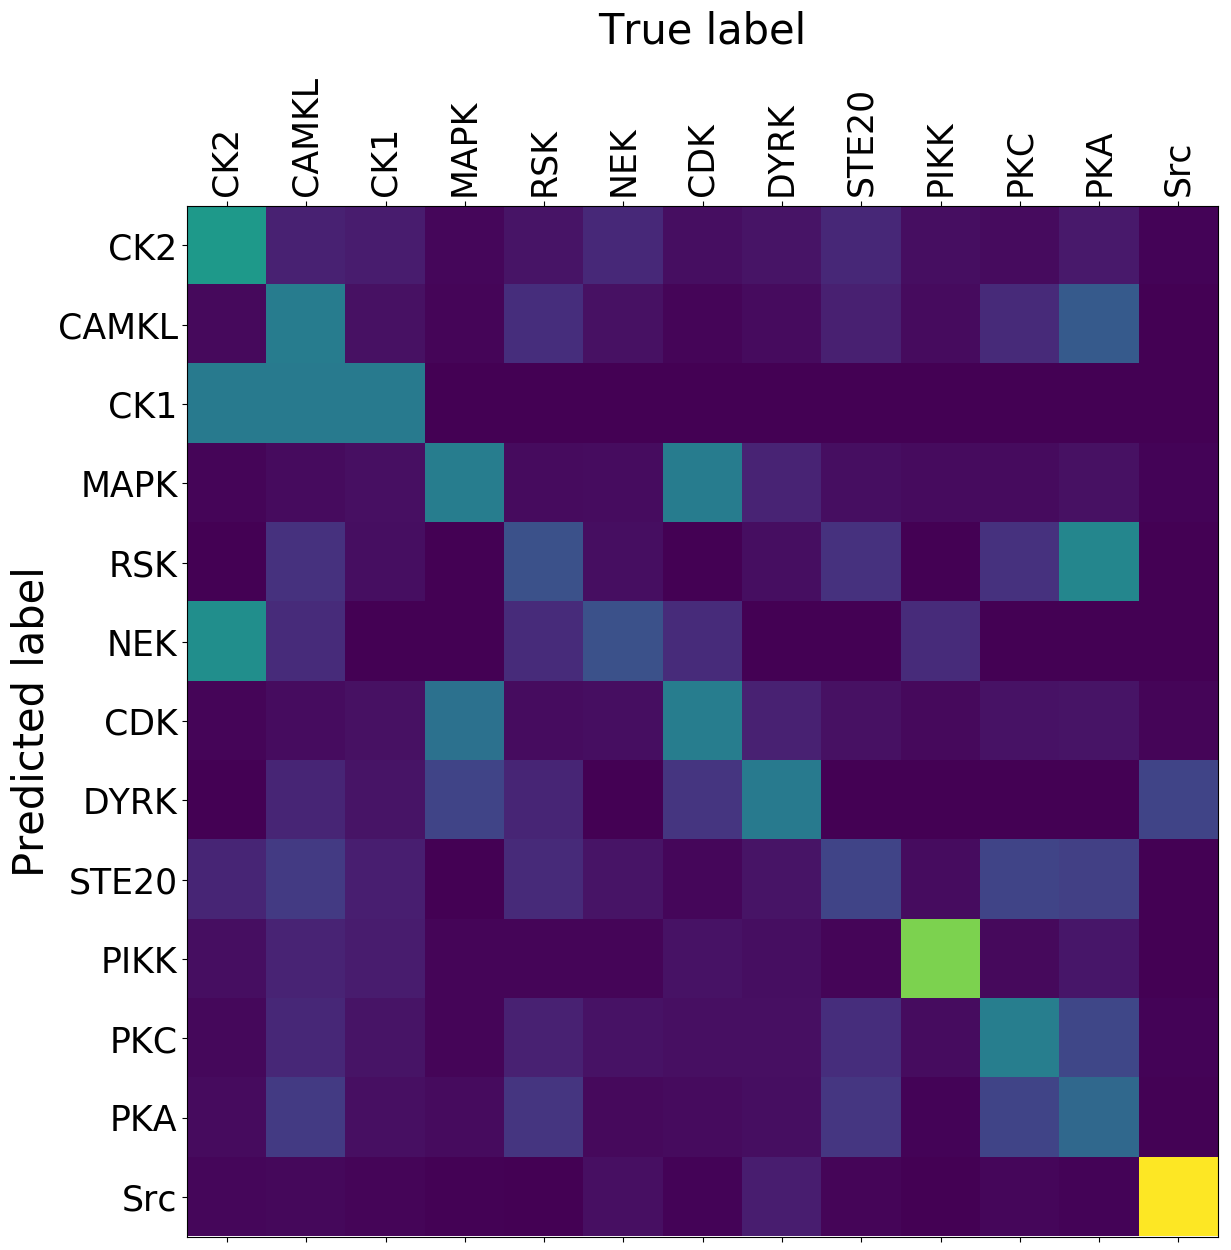

In [51]:
import matplotlib.ticker as ticker

# Normalize by dividing every row by its sum
plt.style.use('default')
for i in range(len(fams)):
    confusion[i] = confusion[i] / confusion[i].sum()
for i in range(len(fams)):
    for j in range(len(fams)):
        if math.isnan(confusion[i][j]) or confusion[i][j]==0:
            confusion[i][j]=0

# Set up plot
fig = plt.figure(figsize=(12.5,12.5))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
# fig.colorbar(cax)

# Set up axes
fs = [x for x in fams]
ax.set_xticklabels([''] + fs, rotation=90)
ax.set_yticklabels([''] + fs)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.title("True label",fontsize=30,y=1.15)
plt.ylabel("Predicted label",fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.savefig("vaeconf")

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [52]:
allDone()

In [53]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.43


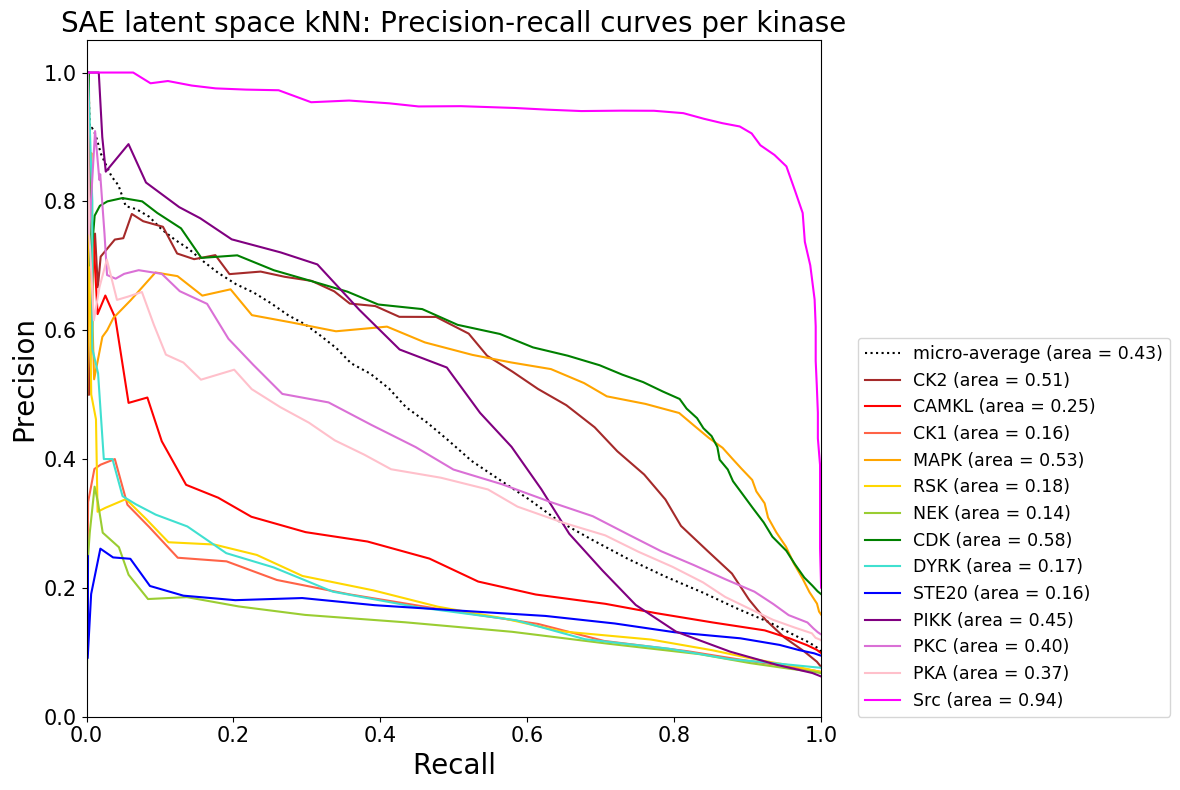

In [54]:
from itertools import cycle
import numpy as np
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red']) # turquoise
colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red','turquoise','brown','tomato',
               'purple','pink','orchid']) 

colors = cycle(['brown','red','tomato','orange','gold','yellowgreen','green','turquoise','blue','purple','orchid','pink',
                'magenta']) 

plt.figure(figsize=(12, 8))
f_scores = numpy.linspace(0.2, 0.8, num=4)
lines = []
labels = []

l, = plt.plot(recall["micro"], precision["micro"], color='black', lw=1.5,linestyle=':')
lines.append(l)
labels.append('micro-average (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range( len(fams) ), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=1.5)
    lines.append(l)
    fclass = fams[i]
    labels.append('{0} (area = {1:0.2f})'
                  ''.format(fclass, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('SAE latent space kNN: Precision-recall curves per kinase',fontsize=20)
plt.legend(lines, labels, loc=(1.05, 0), fontsize=12.5)
plt.tight_layout()
plt.savefig("vae_poo")

plt.show()

In [55]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

FAM_IDC = range(len(fams))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in FAM_IDC:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in FAM_IDC]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in FAM_IDC:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(FAM_IDC)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

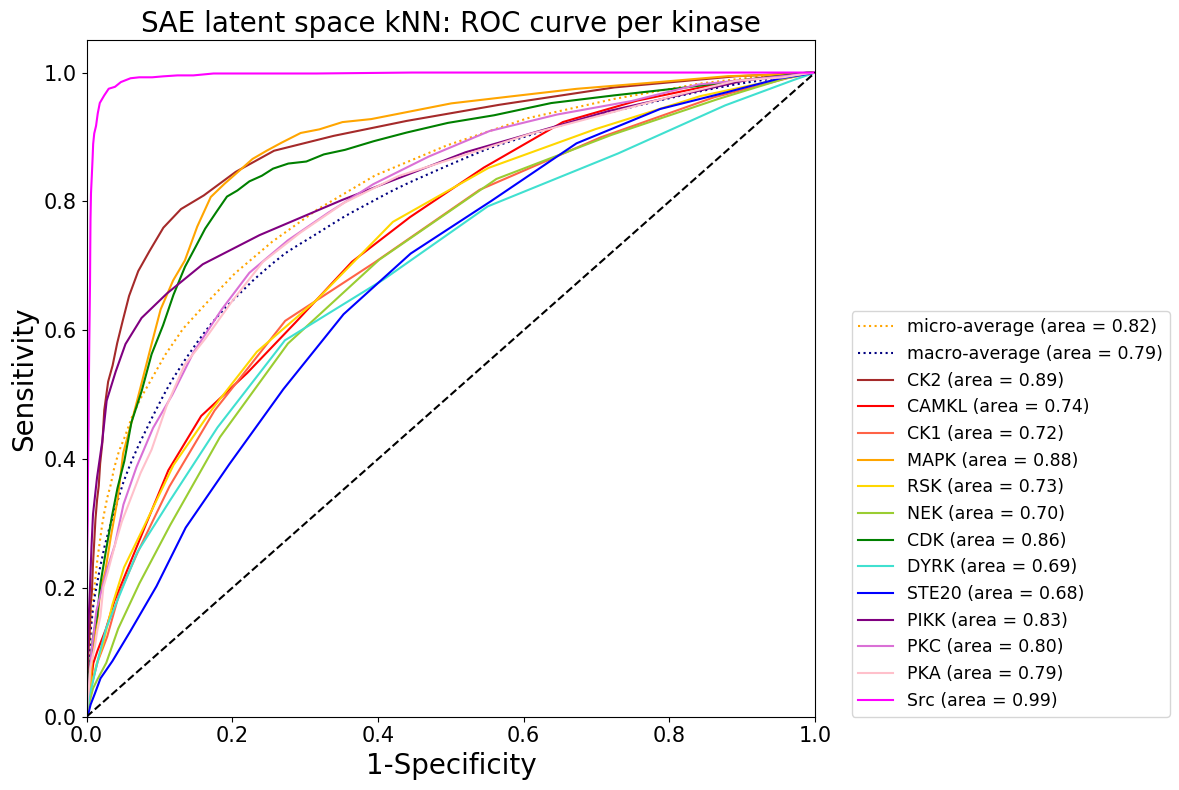

In [56]:


lw = 1.5
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='orange', linestyle=':', linewidth=lw)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=lw)

colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red']) # turquoise
colors = cycle(['brown','red','tomato','orange','gold','yellowgreen','green','turquoise','blue','purple','orchid','pink',
                'magenta']) 

for i, color in zip( (FAM_IDC), colors):
    fam = fams[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(fam, roc_auc[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('1-Specificity',fontsize=20)
plt.ylabel('Sensitivity',fontsize=20)
plt.title('SAE latent space kNN: ROC curve per kinase',fontsize=20)
plt.legend(loc=(1.05, 0),fontsize=12.5)
plt.tight_layout()


# plt.savefig('fams_Stat_figs/RNN_ROC_select_testData_200OrMoreMotifs', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig("vaePOOP")
plt.show()

In [57]:
confusion_numpy = confusion
FP = confusion_numpy.sum(axis=0) - np.diag(confusion_numpy)  
FN = confusion_numpy.sum(axis=1) - np.diag(confusion_numpy)
TP = np.diag(confusion_numpy)
TN = confusion_numpy.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print ("TPR:",numpy.mean(TPR))
print ("TNR:",numpy.mean(TNR)) 
print ("PPV:",numpy.mean(PPV)) 
print ("NPV:",numpy.mean(NPV)) 
print ("FPR:",numpy.mean(FPR)) 
print ("FNR:",numpy.mean(FNR)) 
print ("FDR:",numpy.mean(FDR)) 
print ("ACC:",numpy.mean(ACC)) 

TPR: 0.3669527963105042
TNR: 0.9472460663592087
PPV: 0.3798629525382244
NPV: 0.9472752138296088
FPR: 0.05275393364079132
FNR: 0.6330472036894957
FDR: 0.6201370474617754
ACC: 0.9026081225093084


In [ ]:

pos = numpy.array(embeds)
pos

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np 

fam_counts = []
for fIdx,fam in enumerate(motifxFamMatrix.T):
    print (fams[fIdx],numpy.sum(motifxFamMatrix.T[fIdx]))
    fam_counts.append(numpy.sum(motifxFamMatrix.T[fIdx]))
fam_counts = numpy.array(fam_counts)

normalized_fam_counts = fam_counts / np.sqrt(np.sum(fam_counts**2))

for i in range(len(normalized_fam_counts)):
    normalized_fam_counts[i] = 1-normalized_fam_counts[i]
normalized_fam_counts = np.array(normalized_fam_counts) 
normalized_fam_counts = torch.from_numpy( np.array(normalized_fam_counts)) 
normalized_fam_counts = normalized_fam_counts.double()

def famGuessFromMotifCoords(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return fams[category_i], category_i

def multipleFamGuessesFromMotifCoords(output, thresh=0.5):
    out = output.detach().numpy()
    pred_fIdc = numpy.where(out >= thresh)[0]
    return (pred_fIdc)

In [ ]:
def getBatch(idc, BATCH_SIZE):
    
    mIdx_batch = []
    fam_batch = []
    num_of_samps_in_batch = 0

    for i in range (BATCH_SIZE):

        mIdx = random.choice(idc) 
        motif_coords = embedding1[mIdx]
        mIdx_batch.append(torch.tensor(motif_coords).float())   
        
        fIdx = numpy.where(motifxFamMatrix[mIdx]==1)[0]
        fam_tensor = numpy.zeros(len(fams))
        
        for j,val in enumerate(fam_tensor):
            if j in fIdx:
                fam_tensor[j] = 1

        fam_batch.append(torch.tensor(fam_tensor).double())

    
    mIdx_batch = torch.stack(mIdx_batch)
    fam_batch = torch.stack(fam_batch)
            
    return (mIdx_batch, fam_batch)

def testOneFold(model, testIdc, confusion, thresh):
    
    BATCH_SIZE = len(testIdc)
    mIdx_batch, fam_batch = getBatch(testIdc, BATCH_SIZE)
    out = model(mIdx_batch)
    score = 0
    for i,mIdx in enumerate(mIdx_batch):
        fam = fam_batch[i].detach().numpy()
        myFams = numpy.where( fam==1 )[0]
        pred_fam = famGuessFromMotifCoords(out[i])[0]
        if pred_fam in [fams[x] for x in myFams]:
            score+=1

    accuracy = score / BATCH_SIZE
    print("Test accuracy:",accuracy,"\n")
    
    ############################################

    IDC = testIdc

    BATCH_SIZE = len(IDC)
    mIdx_batch, fam_batch = getBatch(IDC, BATCH_SIZE)
    output = model(mIdx_batch).double() # UGH. changed to double . . . .

    for i,mIdx in enumerate(IDC):
        fam = fam_batch[i].detach().numpy()
        true_fIdc = numpy.where( fam==1 )[0]
        pred_fIdc = multipleFamGuessesFromMotifCoords(output[i], thresh)

        for pred_fIdx in pred_fIdc:
            for true_fIdx in true_fIdc:
                confusion[pred_fIdx][true_fIdx] += 1
                
    y_score = output.detach().numpy()
    y_test = numpy.array(fam_batch)

    return (accuracy, confusion, y_score, y_test)

In [ ]:
def trainOneFold(model, trainIdc, num_epochs, BATCH_SIZE):
    
    loss_history = []
    acc_history = []
    
    s = 1
    for epoch in range(num_epochs):
        tot_loss = []
        for bIdx in range(250): #range(())):len(trainIdc) len(motifs) 
            optimizer.zero_grad()
            mIdx_batch, fam_batch = getBatch(trainIdc, BATCH_SIZE)
            output = model(mIdx_batch).double() # UGH. changed to double . . . .
    
            loss = criterion(output, fam_batch)
            tot_loss.append(loss)
            loss.backward()
            
            optimizer.step()
            
            if bIdx % 25 == 0 :
                print("Iter {}\nEpoch number {}\nCurrent loss {}".format(s,epoch+1, sum(tot_loss)/len(tot_loss) ))
                loss_history.append( sum(tot_loss)/len(tot_loss) )

                # ------ ACCURACY ON TRAINING SET -----
                mIdx_batch, fam_batch = getBatch(trainIdc, BATCH_SIZE)
                out = model(mIdx_batch)
                score = 0
                for i,mIdx in enumerate(mIdx_batch):
                    fam = fam_batch[i].detach().numpy()
                    myFams = numpy.where( fam==1 )[0]
                    pred_fam = famGuessFromMotifCoords(out[i])[0]
                    if i%10==0:
                        print (pred_fam, [fams[x] for x in myFams])
                    if pred_fam in [fams[x] for x in myFams]:
                        score+=1
                accuracy = score / BATCH_SIZE
                acc_history.append(accuracy)
                print("Accuracy:",accuracy,"\n")

            s+=1
            
    return (loss_history, acc_history)

In [ ]:
import torch
import torch.nn as nn

INPUT_DIM = embedding1.shape[1]
HIDDEN_DIM_1 = 75
OUT_DIM = len(fams)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.hidden1 = nn.Linear(INPUT_DIM, HIDDEN_DIM_1)
        self.output = nn.Linear(HIDDEN_DIM_1, OUT_DIM)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, coords): 
        hidden1 = self.hidden1( coords ) 
        output = self.output( hidden1 )
        output = self.softmax( output )
        return output # WORKS BETTER WITH SOFTMAX !!!

In [ ]:
all_losses = []
all_acc_history = []

all_accuracy = []
confusion = torch.zeros(len(fams), len(fams))
all_y_score = []
all_y_test = []

for p,idcPair in enumerate(trainAndTestSets):
    p+=1
    print ("------------------------------------ SET: %s ------------------------------------" % p)
    myModel = Model() 
    criterion = nn.BCEWithLogitsLoss(pos_weight=normalized_fam_counts)
    optimizer = optim.Adam(myModel.parameters(),lr = 0.005 )
    
    myTrainIdc = idcPair[0]
    myTestIdc = idcPair[1]
        
    (loss_history, acc_history) = trainOneFold(myModel, myTrainIdc, num_epochs=5, BATCH_SIZE=32)
    all_losses.append(loss_history)
    all_acc_history.append(acc_history)
    
    (accuracy, confusion, y_score, y_test) = testOneFold(myModel, myTestIdc, confusion, thresh=0.25)
    all_accuracy.append(accuracy)
    all_y_score.append(y_score)
    all_y_test.append(y_test)

In [ ]:
avg_losses = []
for i in range(len(all_losses[0])):
    avg_loss = sum([x[i] for x in all_losses]) / len(all_losses)
    avg_losses.append(avg_loss)
    
avg_acc_history = []
for i in range(len(all_acc_history[0])):
    avg_acc = sum([x[i] for x in all_acc_history]) / len(all_acc_history)
    avg_acc_history.append(avg_acc)
    
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(18,13))
plt.title("ProtVec: MLP Loss",fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Iterations (x25)', fontsize=25)
plt.ylabel('Score', fontsize=25)
plt.plot(avg_losses)
# plt.plot(avg_acc_history)
plt.tight_layout()
# plt.savefig("RNN_3_loss")

In [ ]:
avg_accuracy = sum(all_accuracy)/ len(all_accuracy)
avg_accuracy

In [ ]:
for i in range(len(fams)):
    for j in range(len(fams)):
        if confusion[i][j]==0:
            confusion[i][j]=0.0000001

In [ ]:
# Normalize by dividing every row by its sum
plt.style.use('default')
for i in range(len(fams)):
    confusion[i] = confusion[i] / confusion[i].sum()
# for i in range(len(fams)):
#     for j in range(len(fams)):
#         if math.isnan(confusion[i][j]) or confusion[i][j]==0:
#             confusion[i][j]=0

# Set up plot
fig = plt.figure(figsize=(12.5,12.5))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
# fig.colorbar(cax)

# Set up axes
fs = [x for x in fams]
ax.set_xticklabels([''] + fs, rotation=90)
ax.set_yticklabels([''] + fs)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# plt.title("RNN: Confusion matrix",fontsize=30,y=1.15)
plt.title("True label",fontsize=30,y=1.15)
plt.ylabel("Predicted label",fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.savefig("poooo")


# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
y_test = []
for res in all_y_test:
    y_test.extend([x for x in res])

y_test = numpy.array(y_test)

y_score = []
for res in all_y_score:
    y_score.extend([x for x in res])

y_score = numpy.array(y_score)

In [ ]:
from itertools import chain
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(fams)):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

In [ ]:
from itertools import cycle
import numpy as np
plt.style.use('default')

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red']) # turquoise
colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red','turquoise','brown','tomato',
               'purple','pink','orchid']) 

colors = cycle(['brown','red','tomato','orange','gold','yellowgreen','green','turquoise','blue','purple','orchid','pink',
                'magenta']) 

plt.figure(figsize=(12, 8))
f_scores = numpy.linspace(0.2, 0.8, num=4)
lines = []
labels = []

l, = plt.plot(recall["micro"], precision["micro"], color='black', lw=1.5,linestyle=':')
lines.append(l)
labels.append('micro-average (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range( len(fams) ), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=1.5)
    lines.append(l)
    fclass = fams[i]
    labels.append('{0} (area = {1:0.2f})'
                  ''.format(fclass, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('ProtVec MLP: Precision-recall curves per kinase',fontsize=20)
plt.legend(lines, labels, loc=(1.05, 0), fontsize=12.5)
plt.tight_layout()
plt.savefig("poo")

plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

FAM_IDC = range(len(fams))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in FAM_IDC:
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in FAM_IDC]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in FAM_IDC:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(FAM_IDC)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:
# Plot all ROC curves


lw = 1.5
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='orange', linestyle=':', linewidth=lw)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=lw)

colors = cycle(['blue', 'yellowgreen', 'darkorange', 'magenta', 'green','gold','red']) # turquoise
colors = cycle(['brown','red','tomato','orange','gold','yellowgreen','green','turquoise','blue','purple','orchid','pink',
                'magenta']) 

for i, color in zip( (FAM_IDC), colors):
    fam = fams[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='{0} (area = {1:0.2f})'
             ''.format(fam, roc_auc[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('1-Specificity',fontsize=20)
plt.ylabel('Sensitivity',fontsize=20)
plt.title('ProtVec MLP: ROC curve per kinase',fontsize=20)
plt.legend(loc=(1.05, 0),fontsize=12.5)
plt.tight_layout()


# plt.savefig('fams_Stat_figs/RNN_ROC_select_testData_200OrMoreMotifs', bbox_extra_artists=(lgd,),bbox_inches='tight')
plt.savefig("POOP")
plt.show()

In [ ]:
confusion_numpy = confusion.detach().numpy()
FP = confusion_numpy.sum(axis=0) - np.diag(confusion_numpy)  
FN = confusion_numpy.sum(axis=1) - np.diag(confusion_numpy)
TP = np.diag(confusion_numpy)
TN = confusion_numpy.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print ("TPR:",numpy.mean(TPR))
print ("TNR:",numpy.mean(TNR)) 
print ("PPV:",numpy.mean(PPV)) 
print ("NPV:",numpy.mean(NPV)) 
print ("FPR:",numpy.mean(FPR)) 
print ("FNR:",numpy.mean(FNR)) 
print ("FDR:",numpy.mean(FDR)) 
print ("ACC:",numpy.mean(ACC)) 